# DQN Grid Search

This script is an extension to the inverted pendulum DQN algorithm in inv_pend.ipynb. This scripts automates the grid search in a hyperparameter space to explore the best performance of DQN.





TODO
- [ ] Package functions related to the experiment in a `GridSearch` class
    - **Attributes:**
        - Hyperparameters - model arch, lr , buffer_size, min_replay_szie, target_update_freq, gamma, eps_start, eps_end, eps_decay, episode_train, and batch_size
        - The simulation environment
    - **Methods:** 
        - `create_directory()` - for storing the training results for each hyperparameter configuration
        - `eps_greedy_policy()` - for picking out an action given the observation
        - `DQN_train()` - for training a Q network from simulation

- [ ] Save the model (parameters and architecture) following training in the grid searchd

In [ ]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym
import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run
import re                                               # For checking the latest trial #
from contextlib import redirect_stdout

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Setup

In [ ]:
class QNet_MLP(nn.Module):
    ''' A QNetwork class that dynamically initialize an MLP Q Net'''
    def __init__(self,input_dim,output_dim,hidden_layer = [64,32]):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for size in hidden_layer:
            self.layers.append(nn.Linear(self.input_dim, size))
            self.input_dim = size
        
        self.layers.append(nn.Linear(self.input_dim,self.output_dim))

        self.cuda()
    
    def forward(self, input_data):
        for layer in self.layers[:-1]:
            input_data = torch.relu(layer(input_data))
        return self.layers[-1](input_data)

In [ ]:
def create_directory(model_id: int,
                     lr: float, 
                     gamma: float,
                     epsilon_decay: int,
                     batch_size: int, 
                     buffer_size: int,
                     target_update_freq: int):
    ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

    Parameters: 
    ------------
    (hyperparameters for differentiating between different directory)
    
    lr : float
        the learning rate to optimize the Q network
    gamma : float 
        the discount rate in Q learning
    epsilon_decay : integer
        the amount of episode over which the exploratory rate (epsilon) decays
    batch_size : integer
        number of experience drawn from replay buffer to train the behaviour network
    buffer_size : integer
        the number of samples in the replay buffer at a time
    target_udpate_freq : integer
        the amount of step count during the training process before updating the target Q net (loading the parameters of the behaviour net onto the target Q Net)
    

    Returns
    ------------
    name_codified : str
        the shortened name for the current experiment 
    hyperparameters_codified : str
        the shortened string of hyperparameter configuration
    OUTPUT_DIR : path
        the directory to which the training results and model (state_dict and architecture) will be saved
    '''
    timestamp = datetime.now().strftime("%y%m%d_%H%M")

    BASE_DIR = os.getcwd()
    RESULT_DIR = os.path.join(BASE_DIR, "inv_pend_results")
    os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

    # Find the trial # of the latest run
    existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
    run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
    trial_number = max(run_numbers,default=-1)+1

    # Create a folder for the run
    name_codified = f"run_{trial_number:05d}"
    OUTPUT_DIR = os.path.join(BASE_DIR,"inv_pend_results",name_codified)
    os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

    
    # Store the training configs in JSON file
    training_params = {
        'model_id': model_id,
        'lr': lr,
        'gamma': gamma,
        'epsilon_decay': epsilon_decay,
        'batch_size': batch_size,
        'buffer_size': buffer_size,
        'target_update_freq': target_update_freq
    }

    # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
    trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
    if os.path.exists(trial_to_param_path):
        with open(trial_to_param_path, "r") as f:
            data = json.load(f)
    else:
        data = {name_codified: []}

    hyperparam_codified = f"{model_id}_{lr}_{buffer_size}_{target_update_freq}_{gamma}_{epsilon_decay}_{batch_size}"
    hyperparam_codified_time = f"{timestamp}_{model_id}_{lr}_{buffer_size}_{target_update_freq}_{gamma}_{epsilon_decay}_{batch_size}"
    data[name_codified] = hyperparam_codified_time

    with open(trial_to_param_path, "w") as f:
        json.dump(data, f, indent=2)

    # Store training parameters in each run 
    param_path = os.path.join(OUTPUT_DIR, "param_config.json")
    with open(param_path, "w") as f:
        json.dump({"parameters": training_params}, f, indent=2)

    return name_codified, hyperparam_codified, OUTPUT_DIR

In [ ]:
def eps_greedy_policy(env, obs, epsilon: float, q_network: QNet_MLP):
    ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(obs, dtype=torch.float32, device = 'cuda').unsqueeze(0)
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()

    return action

In [ ]:
def policy_eval(env_test, q_network, n_episode_test = 500):
    ''' Assess the average reward when following a q_network in a test environment with random state initialization '''
    
    total_reward = 0
    for i in range(n_episode_test):
        obs,_ = env_test.reset()
        done = False
        eps_reward = 0

        while not done:                 # Step thorugh the episode
            action = eps_greedy_policy(env_test, obs, epsilon=0, q_network=q_network)
            next_obs, reward, term, trunc, _ = env_test.step(action)

            eps_reward += reward

            obs = next_obs
            done = term or trunc
    
        total_reward += eps_reward
    average_reward = total_reward / n_episode_test

    return average_reward
    

In [ ]:
def save_model(q_network: nn.Module, optimizer: torch.optim.Optimizer, save_path):
    ''' Function to save the model and optimizer state_dict for inference or continued training '''
    torch.save({
        'model_state_dict': q_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(save_path, 'q_network_checkpoint.pth'))

def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def DQN_train(env: gym.Env, env_test: gym.Env,
              q_network: nn.Module, target_net: nn.Module, optimizer: torch.optim.Optimizer, 
              replay_buffer,
              target_update_freq,
              gamma,
              eps_start, eps_end, eps_decay,
              episode_train,
              batch_size, 
              save_path,
              seed = 42):
    ''' Function to train a policy for a set of hyperparameters '''

    msg = "Training ended, no good model found!"

    reward_history = np.zeros(episode_train)
    epsilon = eps_start
    step_count = 0
    episode = 0
    target_network_update_count = 0

    # Control of early stopping
    consecutive_pass_count = 0           # Number of consecutive episodes where performance exceeds a threshold
    CONSECUTIVE_PASS_LIMIT = 3          # No. of consecutive episodes with higher performance than reward limit
    EPISODE_REWARD_LIMIT = 450
    best_reward = 0
    performance_crit = False
    train_terminated = False
    val_history = {}                    # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    while not train_terminated:     # Experiment level - loop through episodes
        obs, _ = env.reset(seed=seed)
        eps_rewards = 0
    
        while True:                 # Episode level - loop through steps
            action = eps_greedy_policy(env, obs, epsilon, q_network)

            # Interact with the environment
            next_obs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            replay_buffer.append((obs, action, reward, next_obs, done))
            obs = next_obs
            eps_rewards += reward
            step_count += 1

            # Train the Q-net using a batch of samples from the experience replay
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states =        torch.tensor(np.array(states),      dtype = torch.float32,  device='cuda')           # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                actions =       torch.tensor(actions,               dtype = torch.long,     device='cuda').unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                rewards =       torch.tensor(rewards,               dtype = torch.float32,  device='cuda').unsqueeze(1)
                next_states =   torch.tensor(np.array(next_states), dtype = torch.float32,  device = 'cuda')
                dones =         torch.tensor(dones,                 dtype = torch.float32,  device='cuda').unsqueeze(1)
                
                # Compute targets using target network Q(s',a',w_i^-)
                with torch.no_grad():
                    target_q_values = target_net(next_states)       # Find a batch of Q(s',a',w_i^-) from the batch of next_states
                    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                    targets = rewards + gamma * max_target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states
            
                # Compute the current Q values for the actions taken Q(s,a,w_i)
                q_values = q_network(states).gather(1, actions)         # obtain the q_values associated to the actual action taken in each sample

                # Update the parameters of the behaviour q_network
                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Periodically update the target network by loading the weights from the behavior network
            if step_count % target_update_freq == 0:
                target_network_update_count += 1
                target_net.load_state_dict(q_network.state_dict())

            if done:        # End of a training episode
                break

        # Decay epsilon after an episode
        epsilon = max(eps_end, epsilon - (eps_start - eps_end)/eps_decay)

        reward_history[episode] = eps_rewards
        # print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
        # print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

        
        if episode % 10 == 0:                   # print progress periodically
            print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}", end = "\r")

        # Early stopping condition
        if eps_rewards >= EPISODE_REWARD_LIMIT:
            test_reward = policy_eval(env_test, q_network, 100)
            val_history[episode] = [eps_rewards, test_reward]

            if test_reward >= best_reward:           # Set the new best reward
                best_reward = test_reward
                save_model(q_network, optimizer, save_path)
                msg = f"Training terminated due to episode limit, best model saved at episode {episode:5d}"
            if test_reward > EPISODE_REWARD_LIMIT: 
                consecutive_pass_count += 1
            else: consecutive_pass_count = 0
        else:
            consecutive_pass_count = 0
            
        # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
        if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
            performance_crit = True 
            msg = f"Early termination at episode {episode:5d}, desired performance reached"


        episode += 1

        # Checking for early training termination or truncation
        train_terminated = (episode >= episode_train) or (performance_crit)
    print("\n")
    return reward_history, val_history, msg


In [ ]:
# Helper function for EMA filters and plotting data
def EMA_filter(reward: list, alpha):
    ''' Function that runs an exponential moving average filter along a datastream '''
    output = np.zeros(len(reward)+1)
    output[0] = reward[0]
    for idx, item in enumerate(reward):
        output[idx+1] = (1 - alpha) * output[idx] + alpha * item
    
    return output

def plot_reward_hist(reward_history: list, hyperparam_config: str, save_path = None, alpha = 0.1):
    ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
    n_episodes= len(reward_history)
    episodes = range(n_episodes)
    filtered_reward_hist = EMA_filter(reward_history, alpha)

    plt.figure(figsize=(20,6))
    plt.plot(episodes, reward_history[:n_episodes], color = "blue")
    plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
    plt.title(f'Total reward per episode - {hyperparam_config}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(['Total reward','Filtered reward'])

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path,'reward_history.png'))
    plt.show()

In [ ]:
%%script test --no-raise-error
# Test creating the Q network with dynamic hidden layer when specifying the list of hidden nodes

Q_net = QNet_MLP(obs_space,action_space,[64,32])
summary(Q_net, (obs_space,))

## Parameter Set

In [ ]:
model_registry = {
    'DQN_MLP_v0': {
        'class': QNet_MLP,
        'config': [64,32]
    },
    'DQN_MLP_v1': {
        'class': QNet_MLP,
        'config': [32,32]
    },
    'DQN_MLP_v2': {
        
        'class': QNet_MLP,
        'config': [32,16]
    },
    'DQN_MLP_v3': {
        'class': QNet_MLP,
        'config': [16,16]
    }
}

The block below is used for testing the model creation automation (Uncomment the first line to run the test)

In [ ]:
%%script test --no-raise-error
for model in model_registry:
    Q_net = QNet_MLP(obs_space, action_space, model_registry[model]['config'])
    # print(model_registry[model]['config'])
    print(Q_net)

In [ ]:
# Actual parameter grid
param_grid = {
    'MODEL': [model for model in model_registry],
    'LR': [5e-4, 1e-3, 5e-3, 1e-2],
    "BUFFER_SIZE": [1000, 5000, 10000],
    "MIN_REPLAY_SIZE": [1000],
    "TARGET_UPDATE_FREQ": [1000, 5000, 10000],

    "GAMMA": [0.90, 0.95, 0.98],
    "EPSILON_START": [1.0],
    "EPSILON_END": [0.1],
    "EPSILON_DECAY": [1000, 5000, 10000],

    "EPISODE_TRAIN": [5000],                # training truncation criteria
    "BATCH_SIZE": [32, 64, 128]
}

success_criteria = 450                      #


In [ ]:
# Hyperparam grid - vary one at a time
param_grid = {
    'MODEL': ['DQN_MLP_v0'],
    'LR': [5e-4],
    "BUFFER_SIZE": [5000],
    "MIN_REPLAY_SIZE": [1000],
    "TARGET_UPDATE_FREQ": [1000],

    "GAMMA": [0.90, 0.95, 0.98],
    "EPSILON_START": [1.0],
    "EPSILON_END": [0.1],
    "EPSILON_DECAY": [5000],

    "EPISODE_TRAIN": [5000],                # training truncation criteria
    "BATCH_SIZE": [32]
}

success_criteria = 450                      #


In [ ]:
# # Simplified param grid to test functionality
# param_grid = {
#     # 'MODEL': [model for model in model_registry],
#     'MODEL': ['DQN_MLP_v0'],
#     'LR': [5e-4],
#     "BUFFER_SIZE": [5000],
#     "MIN_REPLAY_SIZE": [1000],
#     "TARGET_UPDATE_FREQ": [1000],

#     "GAMMA": [0.95],
#     "EPSILON_START": [1.0],
#     "EPSILON_END": [0.1],
#     "EPSILON_DECAY": [5000],

#     "EPISODE_TRAIN": [5000],                # training truncation criteria
#     "BATCH_SIZE": [32]
# }

# success_criteria = 450                      #


## Grid Search

Using itertools to loop through each combination of hyperparameters

In [ ]:
import itertools
import time
keys, values = zip(*param_grid.items())
# keys, values = param_grid.keys(), param_grid.values()
num_config = len(list(itertools.product(*values)))

# Set fixed seed
seed = 42
np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

for idx, v in enumerate(itertools.product(*values)):

    # Unpacking the hyperparameter configurations
    config = dict(zip(keys,v))
    MODEL_NAME = config['MODEL']
    MODEL_CLASS = model_registry[MODEL_NAME]['class']
    MODEL_CONFIG = model_registry[MODEL_NAME]['config']
    match = re.search(r'v\d+',MODEL_NAME)
    MODEL_ID = match.group(0) if match else 404

    LR = config['LR']
    BUFFER_SIZE = config['BUFFER_SIZE']
    MIN_REPLAY_SIZE = config['MIN_REPLAY_SIZE']
    TARGET_UPDATE_FREQ = config['TARGET_UPDATE_FREQ']
    GAMMA = config['GAMMA']
    EPS_START = config['EPSILON_START']
    EPS_END = config['EPSILON_END']
    EPS_DECAY = config['EPSILON_DECAY']
    EPISODE_TRAIN = config['EPISODE_TRAIN']
    BATCH_SIZE = config['BATCH_SIZE']


    # Re-initialize the environment
    env = gym.make('CartPole-v1')
    env_test = gym.make('CartPole-v1')
    obs,_ = env.reset(seed=seed)

    obs_space = env.observation_space.shape[0]
    action_space = env.action_space.n


    # Re-initialize the NN models
    Q_net = MODEL_CLASS(obs_space,action_space,MODEL_CONFIG)
    target_net = MODEL_CLASS(obs_space,action_space,MODEL_CONFIG)
    target_net.load_state_dict(Q_net.state_dict())
    target_net.eval()

    optimizer = optim.SGD(Q_net.parameters(), lr = LR)
    # optimizer = optim.Adam(Q_net.parameters(), lr = LR)

    # Re-initialize and pre-fill the replay buffer
    replay_buffer = deque(maxlen = BUFFER_SIZE)
    
    obs, _ = env.reset()
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs if not done else env.reset()[0]

    # Create the directory to store results
    _, hyperparam_config, save_path = create_directory(MODEL_ID,LR,GAMMA,EPS_DECAY,BATCH_SIZE,BUFFER_SIZE,TARGET_UPDATE_FREQ)

    # Training information
    print(f'Trial {idx+1}/{num_config} - model {MODEL_NAME}, lr={LR}, buffer={BUFFER_SIZE}, target_freq={TARGET_UPDATE_FREQ}, gamma={GAMMA}, eps_decay={EPS_DECAY}, batch_size={BATCH_SIZE}')
    
    # Train the DQN with the given hyperparameter configuration
    start_time = time.time()
    reward_history, val_history, msg = DQN_train(env, env_test,
                                    Q_net, target_net,optimizer,
                                    replay_buffer,
                                    TARGET_UPDATE_FREQ, GAMMA, 
                                    EPS_START, EPS_END, EPS_DECAY,
                                    EPISODE_TRAIN,
                                    BATCH_SIZE, 
                                    save_path,
                                    seed=seed)
    end_time = time.time()
    print(f"Runtime - {end_time - start_time:.3f}")
    print(msg)

    # Load the best Q net parameter from the experiment
    model_path = os.path.join(save_path,'q _network_checkpoint.pth')
    load_model(Q_net, model_path)

    # Average test reward of the resulting policy
    env_test = gym.make('CartPole-v1')
    average_reward = policy_eval(env_test, Q_net, n_episode_test=500)
    print(f"Validation average reward {average_reward:4.2f}")

    # Store the validation hisotry and average test reward in the param_config JSON file
    param_path = os.path.join(save_path,'param_config.json')
    if os.path.exists(param_path):
        with open(param_path, "r") as f:
            data = json.load(f)
    else:
        data = {}
    data['val_history'] = val_history
    data['test_result'] = average_reward
    
    

    with open(param_path, "w") as f:
        json.dump(data, f, indent=2)
    
    # Display and save the reward history in current trial folderr 
    plot_reward_hist(reward_history, hyperparam_config, save_path)

env.close()

## Load and Simulate Saved Model 


In [ ]:
# Load a model after training

# Manually select a folder/run to load
run_number = 'run_00012'


# Find the paths to the param_config and model checkpoint
RESULT_DIR = os.path.dirname(save_path)
RUN_DIR = os.path.join(RESULT_DIR, run_number)
MODEL_PATH = os.path.join(RUN_DIR,'q_network_checkpoint.pth')

# Find the model configuration
with open(os.path.join(RUN_DIR,"param_config.json"),'r') as f:
    data = json.load(f)
model_id = 'DQN_MLP_' + data['parameters']['model_id']
model_config = model_registry[model_id]['config']

# Create the model according to the model version in the model registry
q_network_loaded = QNet_MLP(obs_space, action_space, model_config)
load_model(q_network_loaded, MODEL_PATH)

In [ ]:
# Create a visual simulation of the network
env_test_visual = gym.make("CartPole-v1")
num_test = 100

for episode in range(num_test):
    obs, _ = env_test_visual.reset()
    done = False
    eps_reward = 0

    while not done:
        action = eps_greedy_policy(env_test_visual, obs, epsilon = 0, q_network=q_network_loaded)
        next_obs, reward, term, trunc, _ = env_test_visual.step(action)

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

# REINFORCE Grid Search

In [ ]:
import gymnasium as gym             # To create the inverted pendulum environment
import torch                        
from torch import nn
import torch.optim as optim
from torch.distributions import Categorical
from torchsummary import summary
import numpy as np
import itertools
import random

import matplotlib.pyplot as plt

import re
import os
import json                         # to save parameters and results
import time                         # to monitor training & validation time
from datetime import datetime       # to create a log of runs


## Parameter & Class Definitions

Define the hyperparameters of the experiment(s), the policy network and value network classes, and the REINFORCE experiment class

In [ ]:
param_grid = {
    'MODEL': ["Policy_MLP_v0", "Policy_MLP_v1"],
    'ALPHA' : [5e-4, 1e-3],
    'BETA' : [1e-3, 5e-3],
    'GAMMA': [0.95, 0.98],
    'N_EPISODE_TRAIN': [5000]
}

N_EPISODE_TEST = 5
CUDA_ENABLED = False
SUCCESS_CRITERIA = 450

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64,64]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        logits = self.layers[-1](input)
        probs = torch.softmax(logits,dim=-1)
        return probs

In [ ]:
class ValueNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[32,32]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        output = self.layers[-1](input)
        return output

In [ ]:
model_registry = {
    "Policy_MLP_v0": {
        'class': PolicyNet,
        'config': [64,32]
    },
    'Policy_MLP_v1': {
        'class': PolicyNet,
        'config': [64,32],
        'value_class': ValueNet,
        'value_config': [32]
    }
}

In [ ]:
class REINFORCE():
    def __init__(self, model_name: str,
                 model_registry,
                 alpha: float,          # learning rate of the policy net
                 beta: float,           # learning rate of the state value net
                 gamma: float,          # discount rate in RL
                 n_episode_train,
                 result_folder = 'inv_pend_REINFORCE_results',
                 seed = 42,
                 cuda_enabled = False,
                 verbose = True):
        
        self.N_EPISODE_TRAIN = n_episode_train
        self.result_folder = result_folder
        self.SEED = seed
        self.CUDA_ENABLED = cuda_enabled
        self.VERBOSE = verbose
        self.LOG_PERIOD = 50

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Initialize the train and validation environments
        self.env = gym.make("CartPole-v1")
        self.env_val = gym.make("CartPole-v1")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.n
        
        ''' Experiment hyperparameters '''
        # Policy model configuration
        self.model_name = model_name
        self.model_class = model_registry[self.model_name]['class']
        self.model_config = model_registry[self.model_name]['config']
        match = re.search(r'v\d+', self.model_name)
        self.model_id = match.group(0) if match else 404

        # Initialize the policy network
        self.policy_net = self.model_class(self.obs_space, self.act_space, self.model_config)
        self.policy_net.apply(self.init_weights)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.alpha)

        # REINFORCE w/ baseline => Value model configuration (if value_class exists)
        if 'value_class' in model_registry[self.model_name]:
            if model_registry[self.model_name]['value_class']:
                self.value_class = model_registry[self.model_name]['value_class']
                self.value_config = model_registry[self.model_name]['value_config']
                self.value_net = self.value_class(self.obs_space, 1, self.value_config)
                self.value_net.apply(self.init_weights)
                self.value_optimizer = optim.Adam(self.value_net.parameters(), lr = self.beta)
                self.BASELINE = True
        else: 
            self.BASELINE = False

        self.save_path = ''
        self.model_path = ''
        self.hyperparam_config = ''
        self.reward_history = []
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        
        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = self.result_folder
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: ""}

        hyperparam_codified = "REINFORCE_"
        hyperparam_codified += "baseline_" if self.BASELINE else ""
        hyperparam_codified += "OOP_"
        hyperparam_codified += "CUDA_" if self.CUDA_ENABLED else "nCUDA_"
        hyperparam_codified += f"{self.model_id}_{self.alpha}_"
        hyperparam_codified += f"{self.beta}_" if self.BASELINE else ""
        hyperparam_codified += f"{self.gamma}"

        hyperparam_codified_time = f"{timestamp}_" + hyperparam_codified

        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'OOP':                  True,
            'CUDA':                 self.CUDA_ENABLED,
            'device':               torch.cuda.get_device_name(torch.cuda.current_device()),
            'model_id':             self.model_id,
            'alpha':                self.alpha,
            'gamma':                self.gamma,
        }
        if self.BASELINE: training_params['beta'] = self.beta

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def get_returns(self, eps_reward_history):
        ''' Function to calculate the return of each time step when given a list of rewards 
        
        Parameters:
        ----------
        rewards : list
            a list of rewards achieved throughout the agent's trajectory
        gamma   : float
            the discount factor
        
        Returns:
        ----------
        returns : list
            a list of returns G_t at each step of the trajectory
            
        For each step of th trajectory (of length T):
        - Extract the rewards from that step onward
        - Each step is multiplied by the corresponding gamma ^ index 
            the first reward received from leaving the state is not discounted
            the last reward received from the trajectory is discouned by gamma ^ (T-1)
        - Sum these values together to obtain the return at each step
        '''
        returns = np.zeros(len(eps_reward_history))
        gamma = self.gamma
        
        for step, _ in enumerate(eps_reward_history):          # step through the "trajectory" or history of reward
            step_reward = eps_reward_history[step:]            # reward from the current step onward

            # List of discounted rewards at each time step
            return_val = [gamma ** i * step_reward[i] for i in range(len(step_reward))]
            return_val = sum(return_val)
            
            returns[step] = return_val
        return returns

    def policy_eval(self, env: gym.Env, n_episode_test = 500, verbose = True):
        ''' Assess the average reward when following the policy net in a test environment with random state initialization
        
        Parameters:
        ----------
        env : gymnasium environment
            this environment can be either the self.env_test or self.env_val environment (whether they are the same)
        n_episode_test : int 
            the number of evaluation episodes
        verbose : bool
            whether to print testing information 

        Return:
        ----------
        average_reward : float
            the average reward received from running the test
        '''

        total_reward = 0
        with torch.no_grad():
            for i in range(n_episode_test):
                obs,_ = env.reset()
                done = False
                eps_reward = 0

                while not done:                 # Step thorugh the episode deterministically (no exploration)
                    obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                    action_probs = self.policy_net(obs_tensor)
                    action_dist = Categorical(action_probs)
                    action = action_dist.sample()
                    next_obs, reward, term, trunc, _ = env.step(action.item())

                    # Strategy 1 - Accumulate the reward from the environment
                    eps_reward += reward

                    # TODO - Strategy 2 - evaluate the strategy based on states

                    obs = next_obs
                    done = term or trunc
            
                total_reward += eps_reward
                if verbose:
                    print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        average_reward = total_reward / n_episode_test
        
        return average_reward
    
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output
    
    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)
        fig, axes = plt.subplots(2,1, figsize=(20,12))
        axes[0].plot(episodes, self.reward_history[:n_episodes], label = 'Total reward', color = "blue")
        axes[0].plot(episodes, filtered_reward_hist[:n_episodes], label = 'Filtered reward', color = "red")
        axes[0].set_title(f'Total reward per episode - {self.hyperparam_config}')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Reward')
        axes[0].legend()

        n_episodes= len(self.value_history)
        episodes = range(n_episodes)
        axes[1].plot(episodes, self.value_history[:n_episodes], label = "v(s_0)", color = "blue")
        # If using baseline with a value estimation model, plot this as well
        if self.BASELINE: axes[1].plot(episodes, self.value_est_history[:n_episodes], label = r"$\hat v$(s_0)", color = "red")
        axes[1].set_title(f'Return in state s_0 - {self.hyperparam_config}')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('v(s_0)')
        axes[1].legend()

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()

    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])

    def train_policy(self):
        msg = "Training ended with no good model found :<"

        # Create the directory to store results
        self.run_number, self.hyperparam_config, self.save_path = self.create_directory()

        # Training information
        if self.BASELINE: title = f"REINFORCE baseline model {self.model_name}, alpha={self.alpha}, beta={self.beta}, gamma={self.gamma}" 
        else: title = f"REINFORCE w/o baseline model {self.model_name}, alpha={self.alpha}, gamma={self.gamma}" 
        if self.VERBOSE: print(title)

        self.reward_history = []                # Track the total reward per episode
        self.val_history = {}                   # Reset the validation history
        self.policy_loss_history = []           # History of loss throughout training
        self.value_loss_history = []
        self.value_history = []                 # History of the v(s_0) calculated using G_t throughout training
        if self.BASELINE: self.value_est_history = []             # History of the \hat v(s_0) calculated using the value net (baseline case)
        self.val_time = 0                       # Time used for validation (s)
        episode = 0

        # Control of early stopping
        consecutive_pass_count = 0
        CONSECUTIVE_PASS_LIMIT = 3
        EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
        best_reward = 0
        self.best_model_episode = None
        performance_crit = False                # Whether desired performance is met consistently
        train_terminated = False
        

        self.train_time_start = time.time()
        while not train_terminated:             # Experiment level - loop through episodes
            obs, _ = self.env.reset(seed=self.SEED)
            obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
            done = False
            step = 0
            eps_reward_history = []
            log_prob_history = []

            if self.BASELINE:
                obs_history = []
                obs_history.append(obs_tensor)
                

            while not done:                     # Episode level - loop through steps in an episode
                step += 1
                action_probs = self.policy_net(obs_tensor)
                action_dist = Categorical(action_probs)
                action = action_dist.sample()

                next_obs, reward, term, trunc, _ = self.env.step(action.item())

                if self.BASELINE: obs_history.append(obs_tensor)
                eps_reward_history.append(reward)
                log_prob_history.append(action_dist.log_prob(action))
                
                obs_tensor = torch.tensor(next_obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                done = term or trunc
            
            # Post episode calculations - returns, total episode reward, and loss
            returns = self.get_returns(eps_reward_history)
            returns = torch.tensor(returns, dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')

            if self.BASELINE: 
                obs_history_tensor = torch.stack(obs_history)
                # print(obs_history_tensor.shape)
                baseline_values = self.value_net(obs_history_tensor)[:-1]
                delta = returns.unsqueeze(dim=1) - baseline_values.detach()
                # Find loss of the value function and update parameters
                value_loss = -torch.sum(baseline_values * delta)
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()

                # Find loss of the policy network and update parameters
                policy_loss = - torch.sum(torch.stack(log_prob_history) * delta)
                self.optimizer.zero_grad()
                policy_loss.backward()
                self.optimizer.step()

            else:
                policy_loss = - torch.sum(torch.stack(log_prob_history) * returns)
                self.optimizer.zero_grad()
                policy_loss.backward()
                self.optimizer.step()
            
            eps_reward = sum(eps_reward_history)
        

            self.reward_history.append(eps_reward)     # Total reward of episode
            self.policy_loss_history.append(policy_loss)
            self.value_history.append(returns[0])
            if self.BASELINE:
                with torch.no_grad():   # Estimate and store \hat v(s_0)
                    self.value_est_history.append(self.value_net(obs_history[0]).item())

            # Optimize the network parameters
            
            # Periodic data logger
            
            if episode % self.LOG_PERIOD == 0 and self.VERBOSE:
                printout_msg = f"Episode {episode:5d}/{self.N_EPISODE_TRAIN}: Total reward = {eps_reward:5.1f}   |   G_0 = {returns[0]: 5.2f}"
                if self.BASELINE: printout_msg += fr"   |   $\hat v(s_0)$ = {self.value_est_history[-1]:6.2f}" 
                print(printout_msg, end='\r')

            # Early stopping condition
            if eps_reward >= EPISODE_REWARD_LIMIT:
                # Evaluate the current good policy and record the validation time
                self.val_time_start = time.time()
                test_reward = self.policy_eval(self.env_val, 20,verbose=False)
                self.val_time += time.time() - self.val_time_start

                self.val_history[episode] = [eps_reward, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                     
                    self.best_model_episode = episode
                    msg = f"Training terminated due to episode limit, best model saved at episode {self.best_model_episode:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0

            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                self.best_model_episode = episode
                performance_crit = True 
                msg = f"Early termination at episode {self.best_model_episode:5d}, desired performance reached"


            episode += 1

            # Checking for early training termination or truncation
            train_terminated = (episode >= self.N_EPISODE_TRAIN) or (performance_crit)

        self.train_time = time.time() - self.train_time_start

        print(f"\nTotal runtime - {self.train_time:5.2f}")
        print(msg)
        return

    def record(self):
        # Load the best policy net parameter from the experiment
        if self.model_path:
            self.load_model()

        # Average test reward of the resulting policy - if best policy does not exists use the last one
        self.env_test = gym.make('CartPole-v1')
        print('Testing the best policy network performance')
        average_reward = self.policy_eval(self.env_test, n_episode_test=500, verbose=True)
        print(f"\nValidation average reward {average_reward:4.2f}")

        # Store the validation history and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path, 'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}

        data['runtime'] = self.train_time
        data['valtime'] = self.val_time
        data['best_model_at'] = self.best_model_episode
        data['val_history'] = self.val_history
        data['test_result'] = average_reward

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()

## REINFORCE Grid Search

In [ ]:
import itertools
keys, values = zip(*param_grid.items())
num_config = len(list(itertools.product(*values)))

seed = 42
np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

for idx, v in enumerate(itertools.product(*values)):
    # Unpack the hyperparameters configurations
    config = dict(zip(keys,v))
    MODEL_NAME = config['MODEL']
    MODEL_CLASS = model_registry[MODEL_NAME]['class']
    MODEL_CONFIG = model_registry[MODEL_NAME]['config']
    match = re.search(r'v\d+',MODEL_NAME)
    MODEL_ID = match.group(0) if match else 404

    ALPHA = config['ALPHA']
    BETA = config['BETA']
    GAMMA = config['GAMMA']
    N_EPISODE_TRAIN = config['N_EPISODE_TRAIN']
    
    REINFORCE_experiment = REINFORCE(MODEL_NAME, 
                                    model_registry,
                                    alpha = ALPHA,
                                    beta = BETA,
                                    gamma = GAMMA,
                                    n_episode_train = N_EPISODE_TRAIN,
                                    seed=42,
                                    cuda_enabled=CUDA_ENABLED,
                                    verbose=True)
    REINFORCE_experiment.train_policy()
    REINFORCE_experiment.record()

## Load and Simulate a Saved Model

In [ ]:
def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
## Manually select a folder/run to load
run_number = 'run_00012'

## Find the paths to the param_config and model checkpoint
# RESULT_DIR = os.path.dirname(REINFORCE_experiment.save_path)    # Can run this after running one experiment
RESULT_DIR = 'c:\\mnguyen\\experiment\\DRL\\gym_exercise\\inv_pend_REINFORCE_results'
RUN_DIR = os.path.join(RESULT_DIR, run_number)
MODEL_PATH = os.path.join(RUN_DIR,'q_network_checkpoint.pth')

## Find the model configuration
with open(os.path.join(RUN_DIR,"param_config.json"),'r') as f:
    data = json.load(f)
model_id = 'Policy_MLP_' + data['parameters']['model_id']
model_config = model_registry[model_id]['config']

# Create the model according to the model version in the model registry
policy_net_loaded = PolicyNet(REINFORCE_experiment.obs_space, REINFORCE_experiment.act_space, model_config)
load_model(policy_net_loaded, MODEL_PATH)

# Create a visual simulation of the network
env_test_visual = gym.make("CartPole-v1",render_mode="human")
num_test = 1

for episode in range(num_test):
    obs, _ = env_test_visual.reset()
    done = False
    eps_reward = 0

    while not done:
        obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if CUDA_ENABLED else 'cpu')
        action_probs = policy_net_loaded(obs_tensor)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        next_obs, reward, term, trunc, _ = env_test_visual.step(action.item())

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

# Actor Critic Grid Search

In [1]:
import gymnasium as gym             # To create the inverted pendulum environment
import torch                        
from torch import nn
import torch.optim as optim
from torch.distributions import Categorical
from torchsummary import summary
import numpy as np
from statistics import mean, stdev

import matplotlib.pyplot as plt

import re
import os
import json                         # to save parameters and results
import time                         # to monitor training & validation time
from datetime import datetime       # to create a log of runs

## Parameter & Class Definition
Define the hyperparameters of the experiment(s), the policy network and value network classes, and the REINFORCE experiment class

In [2]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64,64]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        logits = self.layers[-1](input)
        probs = torch.softmax(logits,dim=-1)
        return probs
    
class ValueNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[32,32]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        output = self.layers[-1](input)
        return output

In [3]:
model_registry = {
    'AC_MLP_v0': {
        'class': PolicyNet,
        'config': [64,64],
        'value_class': ValueNet,
        'value_config': [64,64]
    },
    'AC_MLP_v1': {
        'class': PolicyNet,
        'config': [128],
        'value_class': ValueNet,
        'value_config': [128]
    }
}

In [4]:
param_grid = {
    'MODEL': ["AC_MLP_v0", "AC_MLP_v1"],
    'ALPHA' : [1e-4, 5e-4],
    'BETA' : [1e-3, 5e-3],
    'GAMMA': [0.95, 0.98],
    'N_EPISODE_TRAIN': [5000]
}

N_EPISODE_TEST = 5
CUDA_ENABLED = False
SUCCESS_CRITERIA = 450

In [5]:
class ActorCritic():
    def __init__(self, model_name: str,
                 model_registry,
                 alpha: float,          # learning rate of the policy net
                 beta: float,           # learning rate of the state value net
                 gamma: float,          # discount rate in RL
                 n_episode_train,
                 result_folder = 'inv_pend_AC_results',
                 seed = 42,
                 cuda_enabled = False,
                 verbose = True):
        
        self.N_EPISODE_TRAIN = n_episode_train
        self.result_folder = result_folder
        self.SEED = seed
        self.CUDA_ENABLED = cuda_enabled
        self.VERBOSE = verbose
        self.LOG_PERIOD = 50

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Initialize the train and validation environments
        self.env = gym.make("CartPole-v1")
        self.env_val = gym.make("CartPole-v1")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.n
        
        ''' Experiment hyperparameters '''
        # Policy model configuration
        self.model_name = model_name
        match = re.search(r'v\d+', self.model_name)
        self.model_id = match.group(0) if match else 404

        self.policy_model_class = model_registry[self.model_name]['class']
        self.policy_model_config = model_registry[self.model_name]['config']
        self.value_model_class = model_registry[self.model_name]['value_class']
        self.value_model_config = model_registry[self.model_name]['value_config']

        # Instantiate and initialize the policy network
        self.policy_net = self.policy_model_class(self.obs_space, self.act_space, self.policy_model_config)
        self.policy_net.apply(self.init_weights)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.alpha)
        
        # Instantiate and initialize the state value network
        self.value_net = self.value_model_class(self.obs_space, 1, self.value_model_config)
        self.value_net.apply(self.init_weights)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr = self.beta)

        self.save_path = ''
        self.model_path = ''
        self.hyperparam_config = ''
        self.reward_history = []
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        
        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = self.result_folder
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: ""}

        hyperparam_codified = "AC_"
        hyperparam_codified += "OOP_"
        hyperparam_codified += "CUDA_" if self.CUDA_ENABLED else "nCUDA_"
        hyperparam_codified += f"{self.model_id}_{self.alpha}_{self.beta}_{self.gamma}"
        hyperparam_codified_time = f"{timestamp}_" + hyperparam_codified

        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'OOP':                  True,
            'CUDA':                 self.CUDA_ENABLED,
            'device':               torch.cuda.get_device_name(torch.cuda.current_device()),
            'model_name':           self.model_name,
            'alpha':                self.alpha,
            'beta':                 self.beta,
            'gamma':                self.gamma,
        }

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def get_returns(self, eps_reward_history):
        ''' Function to calculate the return of each time step when given a list of rewards 
        
        Parameters:
        ----------
        rewards : list
            a list of rewards achieved throughout the agent's trajectory
        gamma   : float
            the discount factor
        
        Returns:
        ----------
        returns : list
            a list of returns G_t at each step of the trajectory
            
        For each step of th trajectory (of length T):
        - Extract the rewards from that step onward
        - Each step is multiplied by the corresponding gamma ^ index 
            the first reward received from leaving the state is not discounted
            the last reward received from the trajectory is discouned by gamma ^ (T-1)
        - Sum these values together to obtain the return at each step
        '''
        returns = np.zeros(len(eps_reward_history))
        gamma = self.gamma
        
        for step, _ in enumerate(eps_reward_history):          # step through the "trajectory" or history of reward
            step_reward = eps_reward_history[step:]            # reward from the current step onward

            # List of discounted rewards at each time step
            return_val = [gamma ** i * step_reward[i] for i in range(len(step_reward))]
            return_val = sum(return_val)
            
            returns[step] = return_val
        return returns

    def policy_eval(self, env: gym.Env, n_episode_test = 500, verbose = True):
        ''' Assess the average reward when following the policy net in a test environment with random state initialization
        
        Parameters:
        ----------
        env : gymnasium environment
            this environment can be either the self.env_test or self.env_val environment (whether they are the same)
        n_episode_test : int 
            the number of evaluation episodes
        verbose : bool
            whether to print testing information 

        Return:
        ----------
        average_reward : float
            the average reward received from running the test
        '''

        reward_history = []
        with torch.no_grad():
            for i in range(n_episode_test):
                obs,_ = env.reset()
                done = False
                eps_reward = 0

                while not done:                 # Step thorugh the episode deterministically (no exploration)
                    obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                    action_probs = self.policy_net(obs_tensor)
                    action_dist = Categorical(action_probs)
                    action = action_dist.sample()
                    next_obs, reward, term, trunc, _ = env.step(action.item())

                    # Strategy 1 - Accumulate the reward from the environment
                    eps_reward += reward

                    # TODO - Strategy 2 - evaluate the strategy based on states

                    obs = next_obs
                    done = term or trunc
            
                reward_history.append(eps_reward)
                if verbose:
                    print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        reward_mean = mean(reward_history)
        reward_stdev = stdev(reward_history)
        
        return reward_mean, reward_stdev
    
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output
    
    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)
        fig, axes = plt.subplots(2,1, figsize=(20,12))
        axes[0].plot(episodes, self.reward_history[:n_episodes], label = 'Total reward', color = "blue")
        axes[0].plot(episodes, filtered_reward_hist[:n_episodes], label = 'Filtered reward', color = "red")
        axes[0].set_title(f'Total reward per episode - {self.hyperparam_config}')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Reward')
        axes[0].legend()

        n_episodes= len(self.value_history)
        episodes = range(n_episodes)
        axes[1].plot(episodes, self.value_history[:n_episodes], label = "v(s_0)", color = "blue")
        # If using baseline with a value estimation model, plot this as well
        axes[1].plot(episodes, self.value_est_history[:n_episodes], label = r"$\hat v$(s_0)", color = "red")
        axes[1].set_title(f'Return in state s_0 - {self.hyperparam_config}')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('v(s_0)')
        axes[1].legend()

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()

    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])

    def train_policy(self):
        msg = "Training ended with no good model found :<"

        # Create the directory to store results
        self.run_number, self.hyperparam_config, self.save_path = self.create_directory()

        # Training information
        title = f"Actor Critic   |   Model {self.model_name}, alpha={self.alpha}, beta={self.beta}, gamma={self.gamma}" 
        if self.VERBOSE: print(title)

        self.reward_history = []                # Track the total reward per episode
        self.val_history = {}                   # Reset the validation history
        self.value_history = []                 # History of the v(s_0) calculated using G_t throughout training
        self.value_est_history = []             # History of the \hat v(s_0) calculated using the value net (baseline case)
        self.val_time = 0                       # Time used for validation (s)
        episode = 0

        # Control of early stopping
        consecutive_pass_count = 0
        CONSECUTIVE_PASS_LIMIT = 3
        EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
        best_reward = 0
        self.best_model_episode = None
        performance_crit = False                # Whether desired performance is met consistently
        train_terminated = False
        

        self.train_time_start = time.time()
        while not train_terminated:             # Experiment level - loop through episodes
            obs, _ = self.env.reset(seed=self.SEED)
            obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
            obs_init_tensor = obs_tensor
            done = False
            step = 0
            eps_reward_history = []

            while not done:                     # Episode level - loop through steps in an episode
                action_probs = self.policy_net(obs_tensor)
                action_dist = Categorical(action_probs)
                action = action_dist.sample()

                next_obs, reward, term, trunc, _ = self.env.step(action.item())
                done = term or trunc
                current_state_value = self.value_net(obs_tensor)
                next_obs_tensor = torch.tensor(next_obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                with torch.no_grad():
                    if done: target_state_value = torch.tensor([reward], dtype=torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
                    else: target_state_value = reward + self.gamma * self.value_net(next_obs_tensor)
                delta = target_state_value - current_state_value
                
                # Find and optimize the value loss
                value_loss = nn.MSELoss()(current_state_value, target_state_value)
                # value_loss = delta.pow(2)
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()
                
                # Find and optimize the policy loss
                policy_loss = - delta.detach() * action_dist.log_prob(action)
                self.optimizer.zero_grad()
                policy_loss.backward()
                self.optimizer.step()

                eps_reward_history.append(reward)
                obs_tensor = next_obs_tensor
                
                step += 1
                
            # print(step)
            # print(f"\nFinal value loss: {value_loss} \nFinal policy loss: {policy_loss}")
            ## Post episode calculations
            # Calculating return state s_0
            returns = self.get_returns(eps_reward_history)
            self.value_history.append(returns[0])

            eps_reward = sum(eps_reward_history)
            self.reward_history.append(eps_reward)     # Total reward of episode
            
            with torch.no_grad():   # Estimate and store \hat v(s_0)
                self.value_est_history.append(self.value_net(obs_init_tensor).item())
            
            # Periodic data logger
            
            if episode % self.LOG_PERIOD == 0 and self.VERBOSE:
                printout_msg = f"Episode {episode:5d}/{self.N_EPISODE_TRAIN}: Total reward = {eps_reward:5.1f}   |   G_0 = {returns[0]: 5.2f}   |   $\hat v(s_0)$ = {self.value_est_history[-1]:6.2f}" 
                print(printout_msg, end='\r')

            # Early stopping condition
            if eps_reward >= EPISODE_REWARD_LIMIT:
                # Evaluate the current good policy and record the validation time
                self.val_time_start = time.time()
                test_reward, _ = self.policy_eval(self.env_val, 20, verbose=False)
                self.val_time += time.time() - self.val_time_start

                self.val_history[episode] = [eps_reward, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                    self.save_model()
                    self.best_model_episode = episode
                    msg = f"Training terminated due to episode limit, best model saved at episode {self.best_model_episode:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0

            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                self.best_model_episode = episode
                performance_crit = True 
                msg = f"Early termination at episode {self.best_model_episode:5d}, desired performance reached"


            episode += 1

            # Checking for early training termination or truncation
            train_terminated = (episode >= self.N_EPISODE_TRAIN) or (performance_crit)

        self.train_time = time.time() - self.train_time_start

        print(f"\nTotal runtime - {self.train_time:5.2f}")
        print(msg)
        return

    def record(self):
        # Load the best policy net parameter from the experiment
        if self.model_path:
            self.load_model()

        # Average test reward of the resulting policy - if best policy does not exists use the last one
        self.env_test = gym.make('CartPole-v1')
        print('Testing the best policy network performance')
        reward_mean, reward_stdev = self.policy_eval(self.env_test, n_episode_test=500, verbose=True)
        print(f"\nValidation average reward {reward_mean:4.2f} (SD = {reward_stdev:4.2f})")

        # Store the validation history and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path, 'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}

        data['runtime'] = self.train_time
        data['valtime'] = self.val_time
        data['best_model_at'] = self.best_model_episode
        data['val_history'] = self.val_history
        data['test_result'] = [reward_mean, reward_stdev]

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()

## Grid Search

Actor Critic   |   Model AC_MLP_v0, alpha=0.0001, beta=0.001, gamma=0.95
Episode   450/5000: Total reward = 102.0   |   G_0 =  19.89   |   $\hat v(s_0)$ =  23.64
Total runtime - 103.85
Early termination at episode   467, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 497.83 (SD = 8.76)


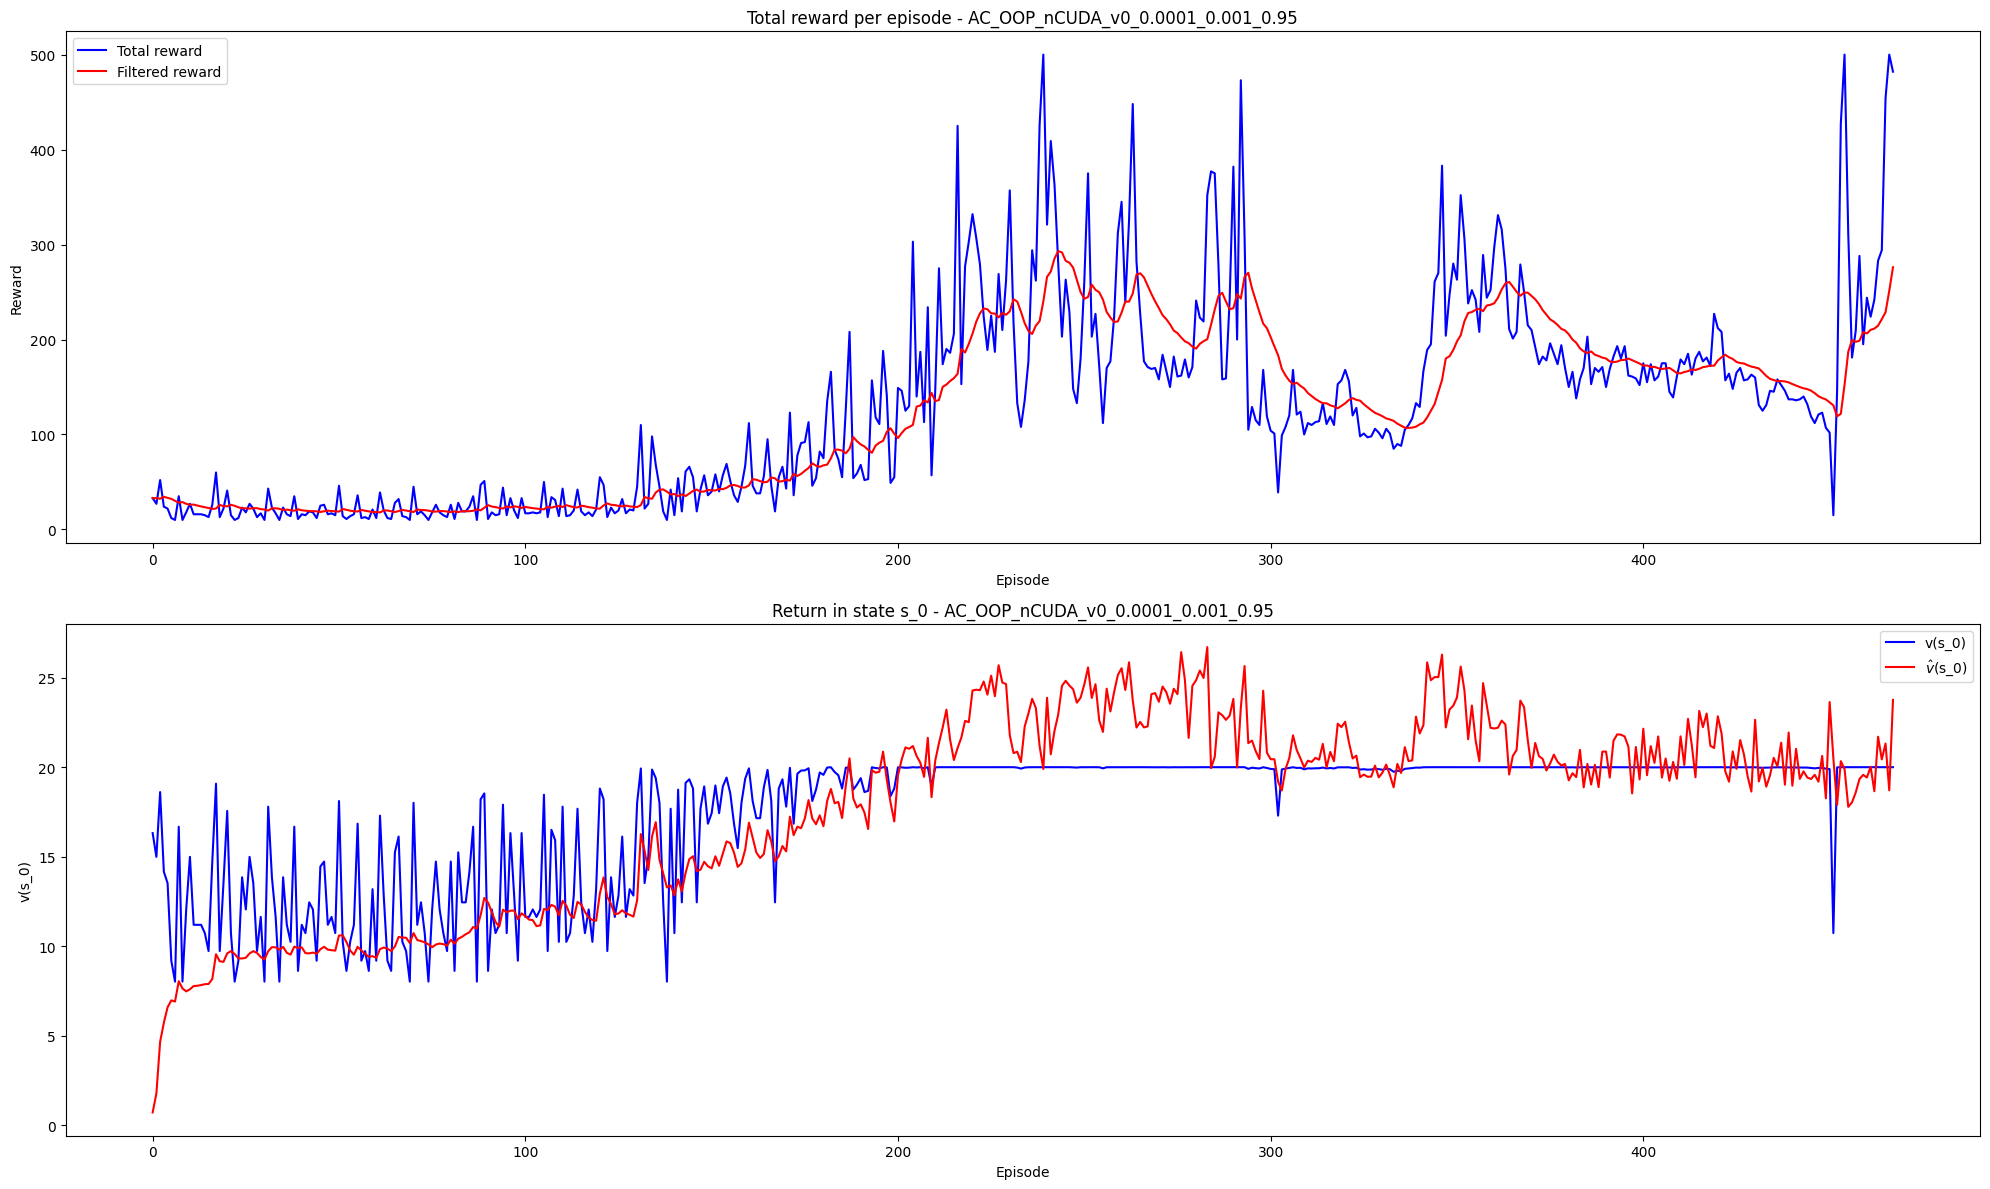

Actor Critic   |   Model AC_MLP_v0, alpha=0.0001, beta=0.001, gamma=0.98
Episode   400/5000: Total reward = 246.0   |   G_0 =  49.65   |   $\hat v(s_0)$ =  57.73
Total runtime - 93.77
Early termination at episode   406, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 492.05 (SD = 17.68)


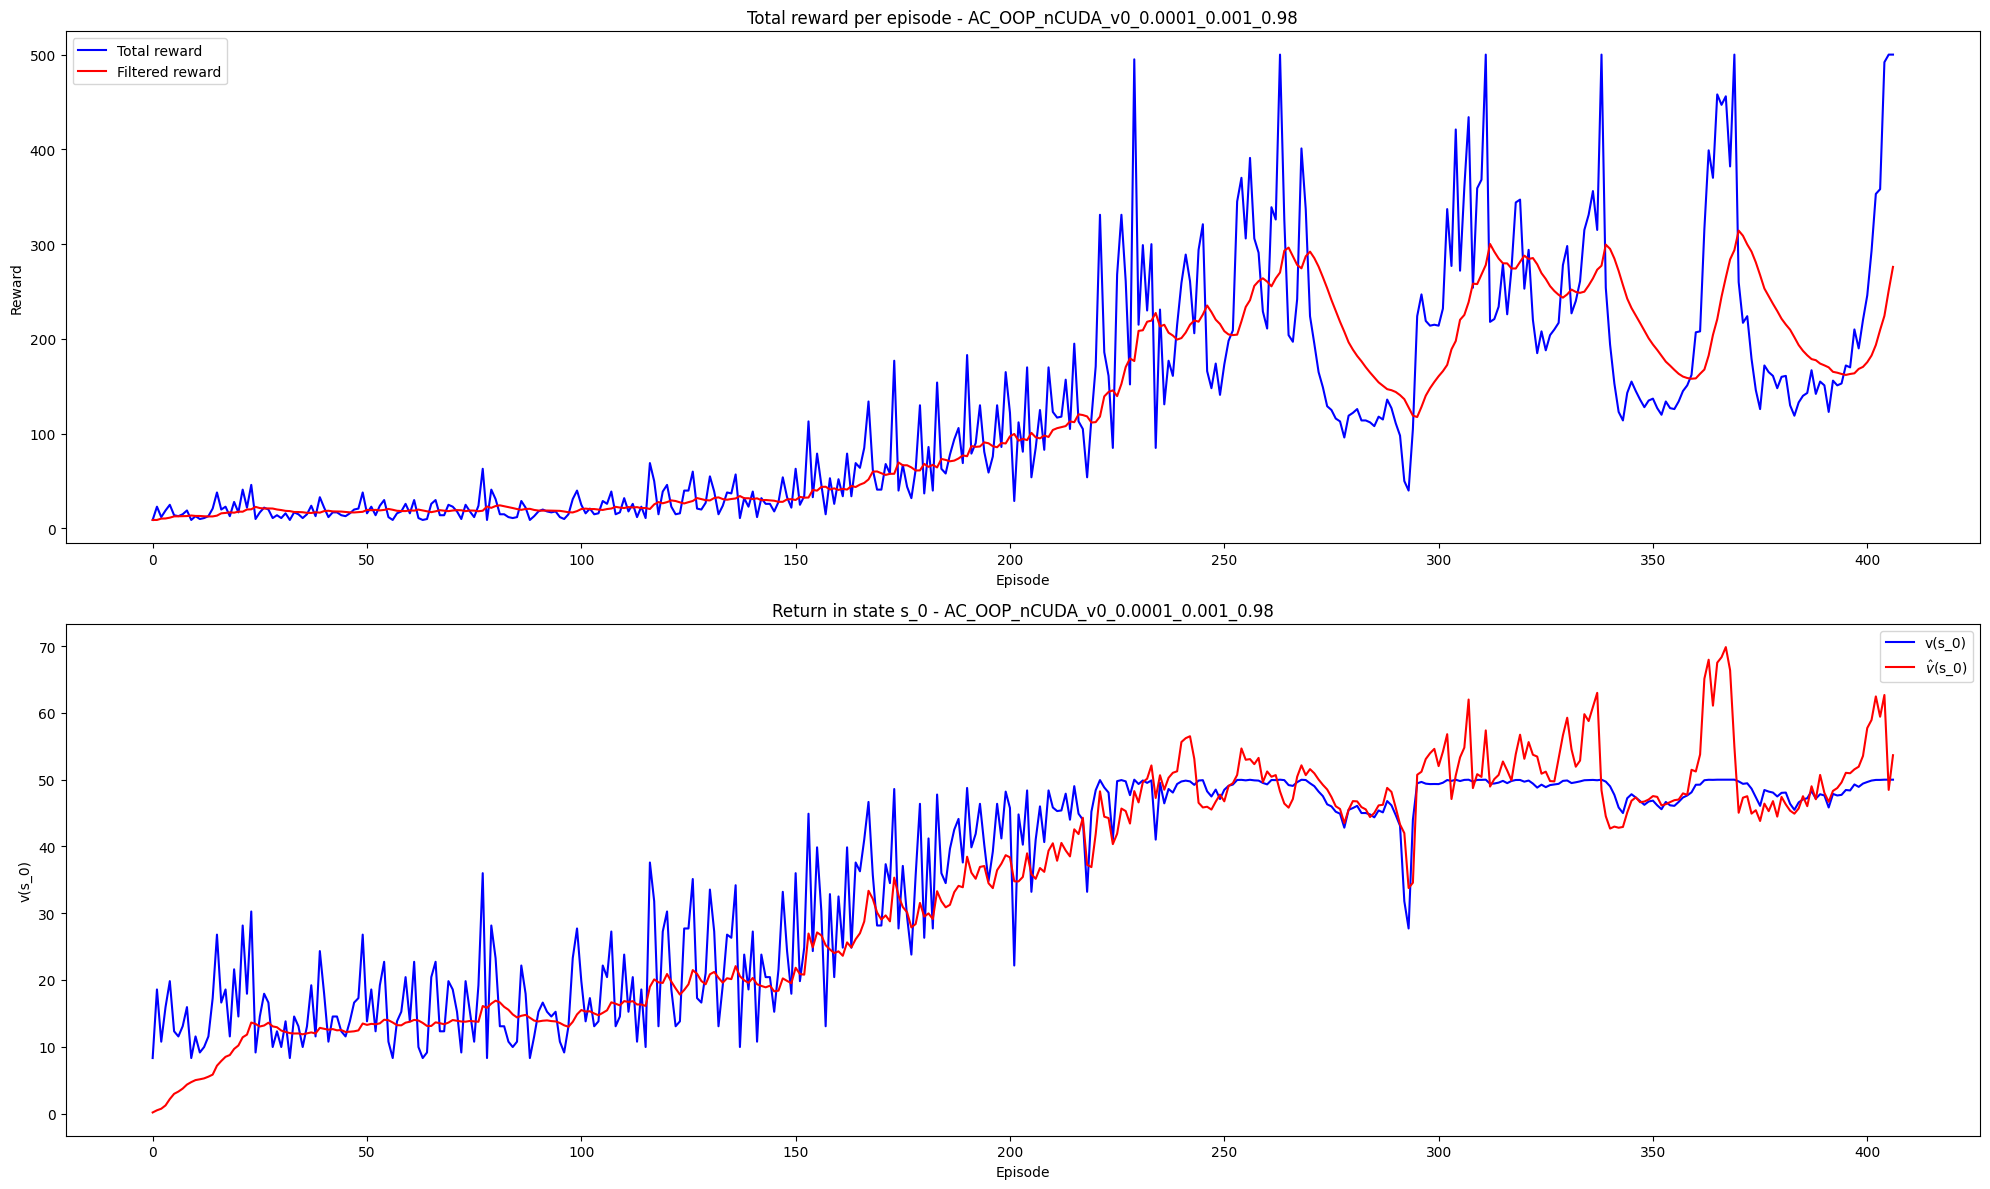

Actor Critic   |   Model AC_MLP_v0, alpha=0.0001, beta=0.005, gamma=0.95
Episode   250/5000: Total reward = 197.0   |   G_0 =  20.00   |   $\hat v(s_0)$ =  23.12
Total runtime - 67.51
Early termination at episode   274, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 472.57 (SD = 71.41)


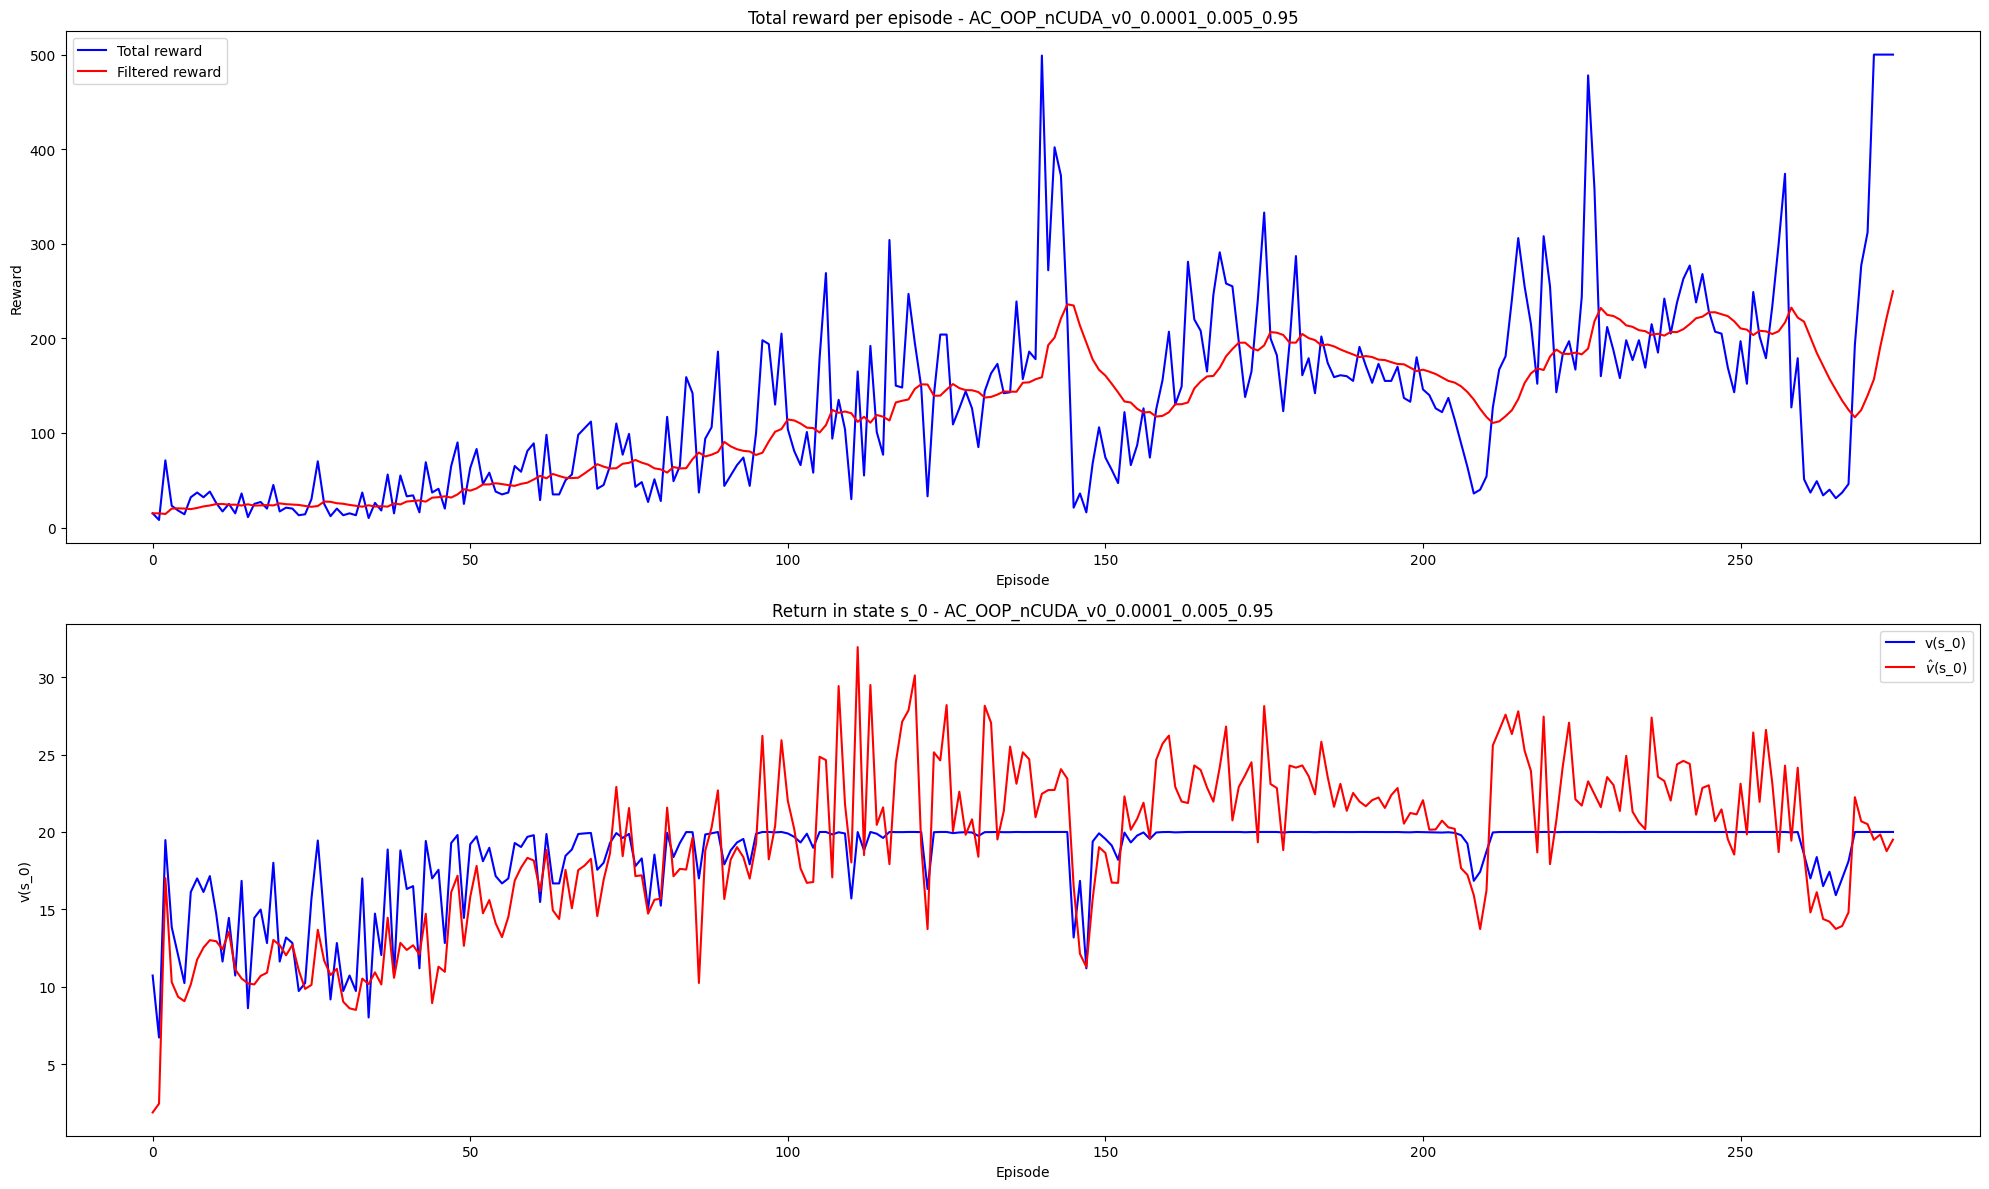

Actor Critic   |   Model AC_MLP_v0, alpha=0.0001, beta=0.005, gamma=0.98
Episode   250/5000: Total reward = 138.0   |   G_0 =  46.92   |   $\hat v(s_0)$ =  49.01
Total runtime - 93.47
Early termination at episode   294, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 465.54 (SD = 82.46)


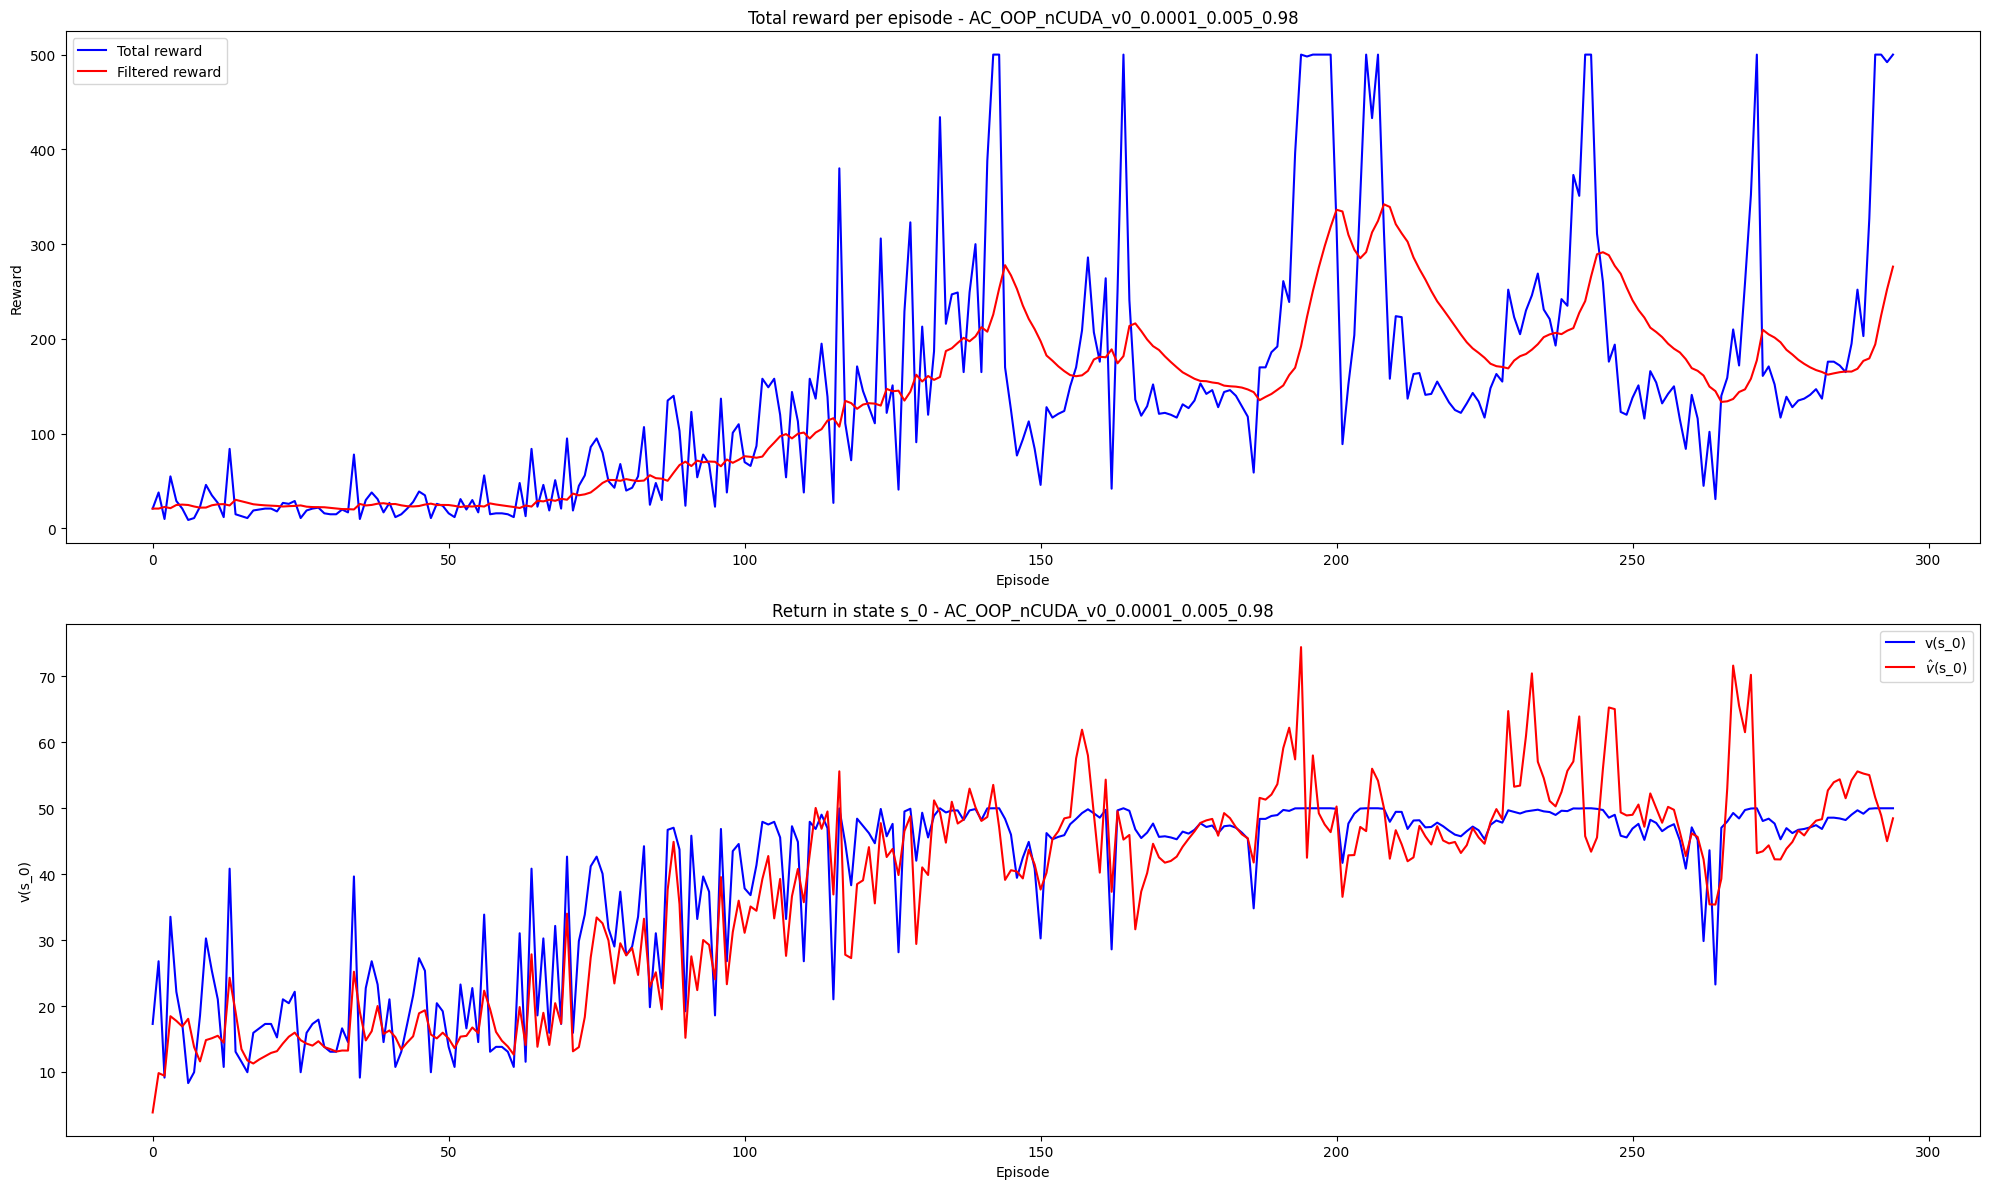

Actor Critic   |   Model AC_MLP_v0, alpha=0.0005, beta=0.001, gamma=0.95
Episode   700/5000: Total reward = 500.0   |   G_0 =  20.00   |   $\hat v(s_0)$ =  19.66
Total runtime - 152.27
Early termination at episode   701, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 500.00 (SD = 0.00)


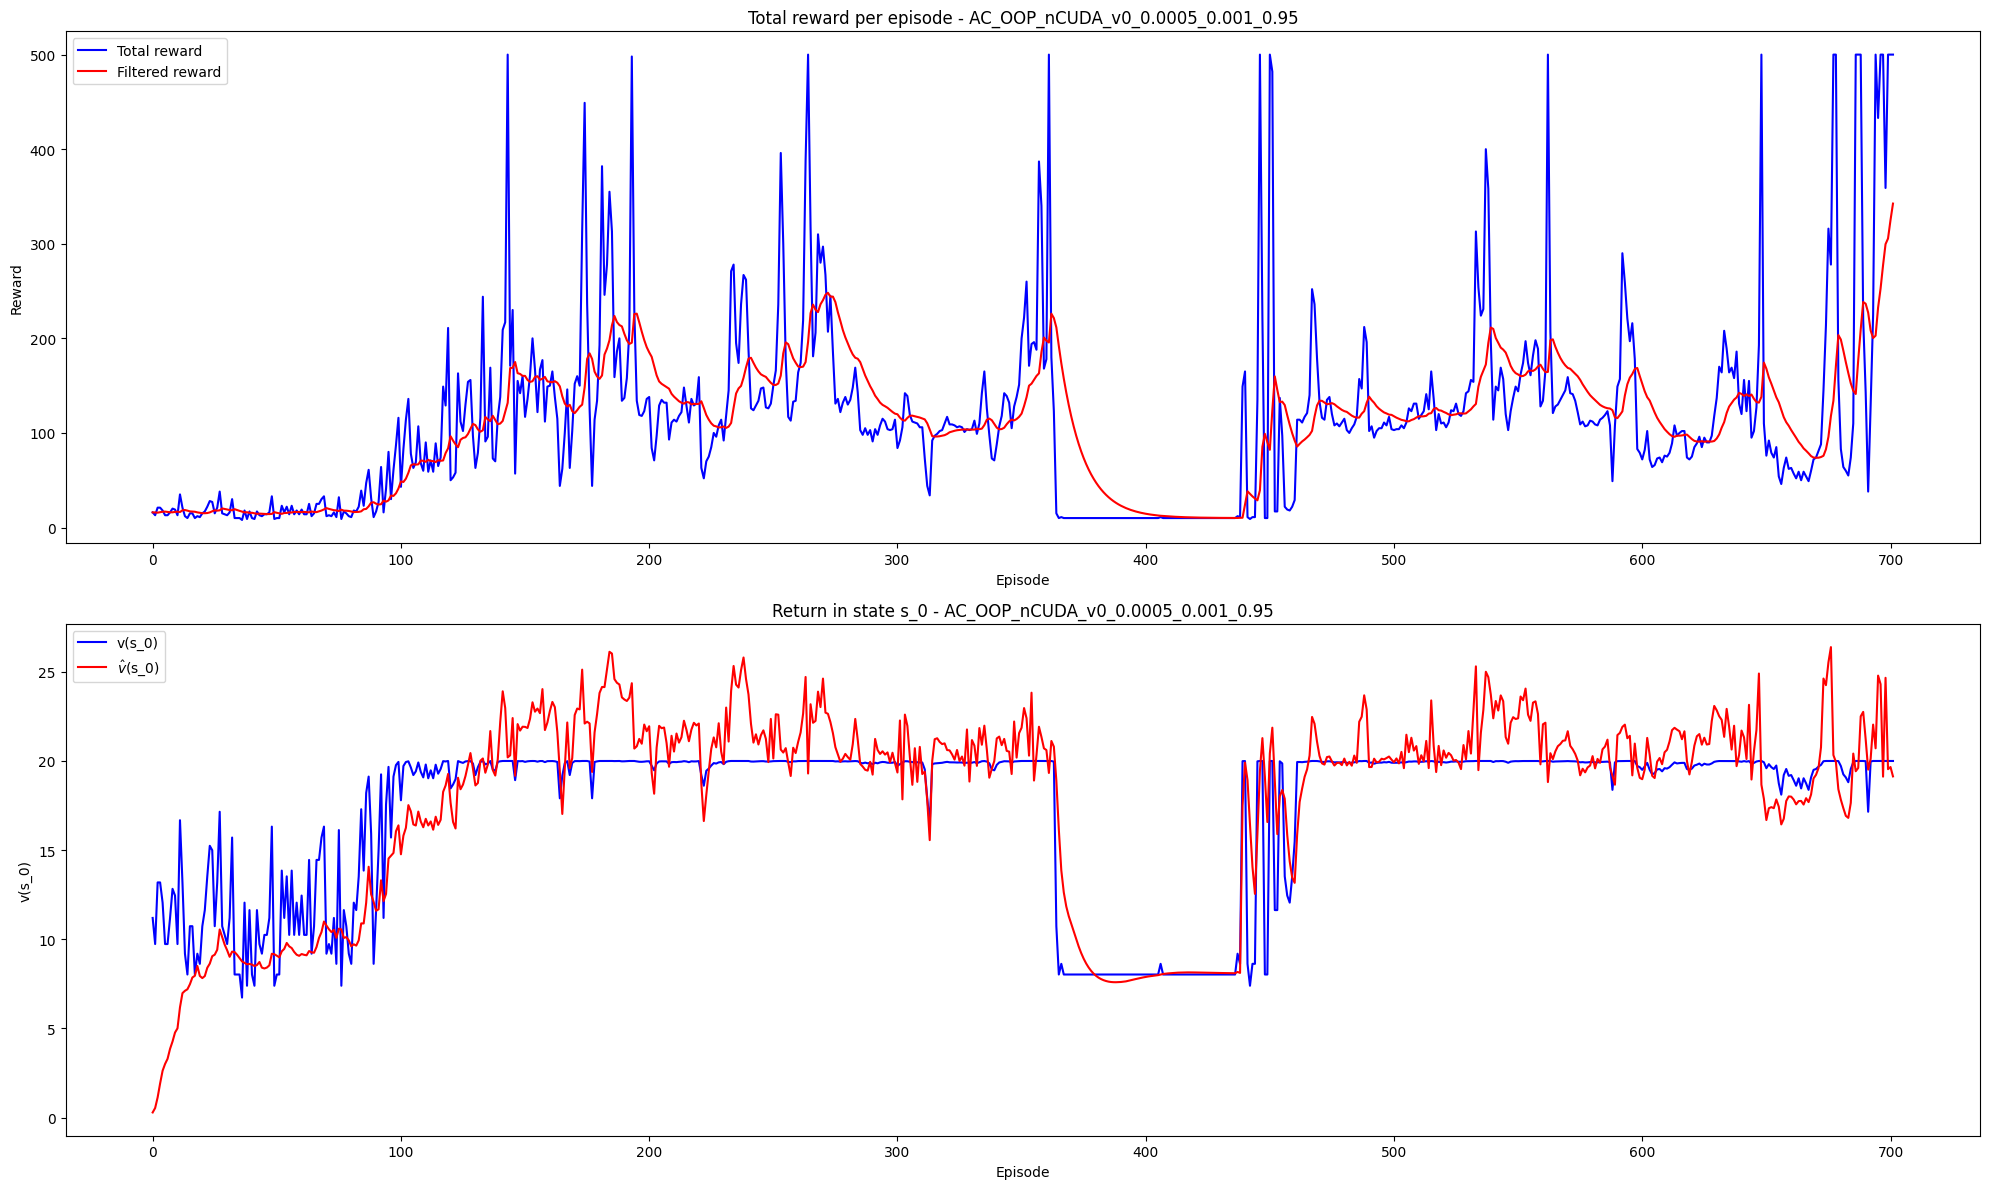

Actor Critic   |   Model AC_MLP_v0, alpha=0.0005, beta=0.001, gamma=0.98
Episode   200/5000: Total reward = 500.0   |   G_0 =  50.00   |   $\hat v(s_0)$ =  50.29
Total runtime - 36.69
Early termination at episode   237, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 499.99 (SD = 0.31)


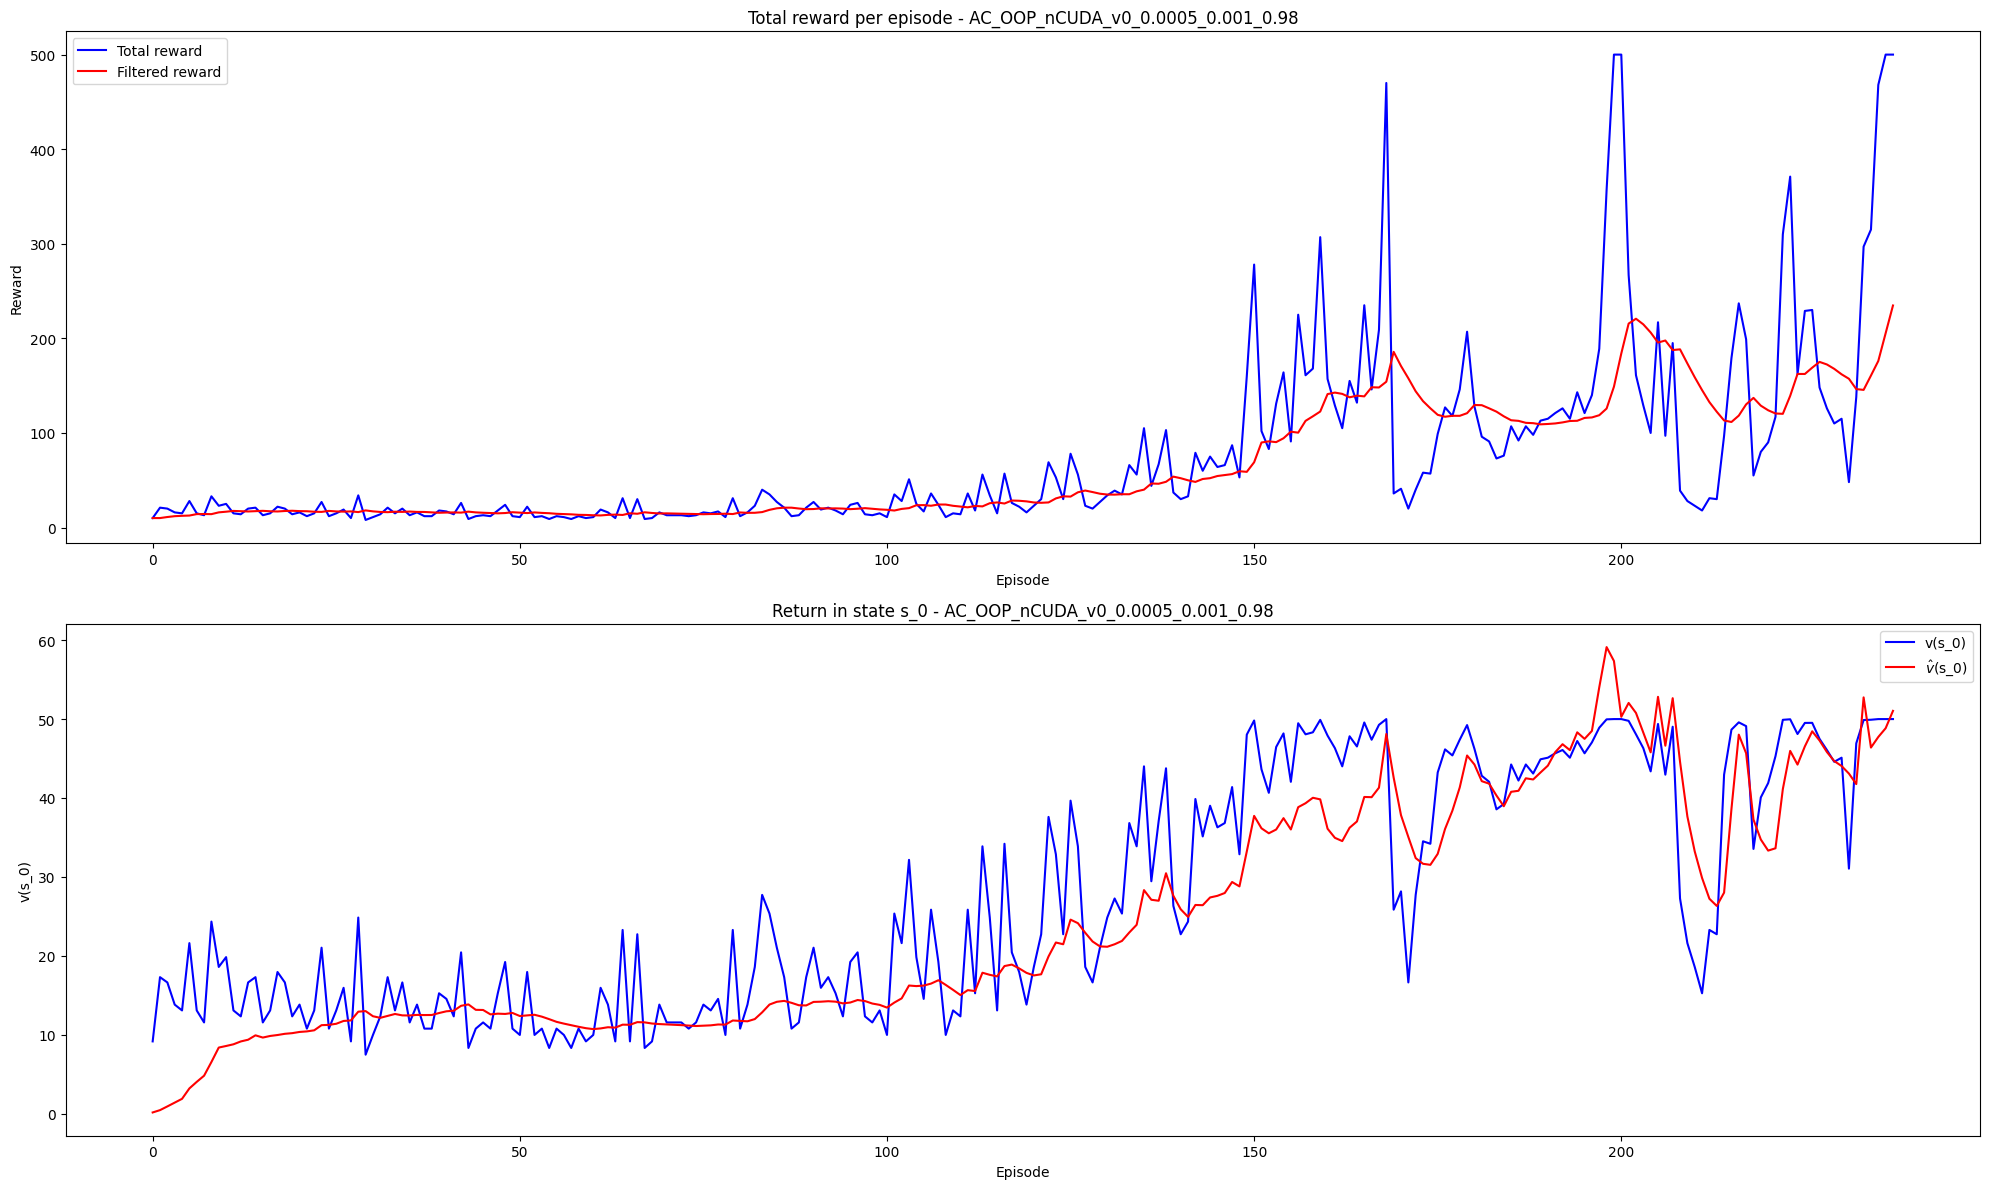

Actor Critic   |   Model AC_MLP_v0, alpha=0.0005, beta=0.005, gamma=0.95
Episode  2550/5000: Total reward =  22.0   |   G_0 =  13.53   |   $\hat v(s_0)$ =  12.94
Total runtime - 200.87
Early termination at episode  2565, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 500.00 (SD = 0.00)


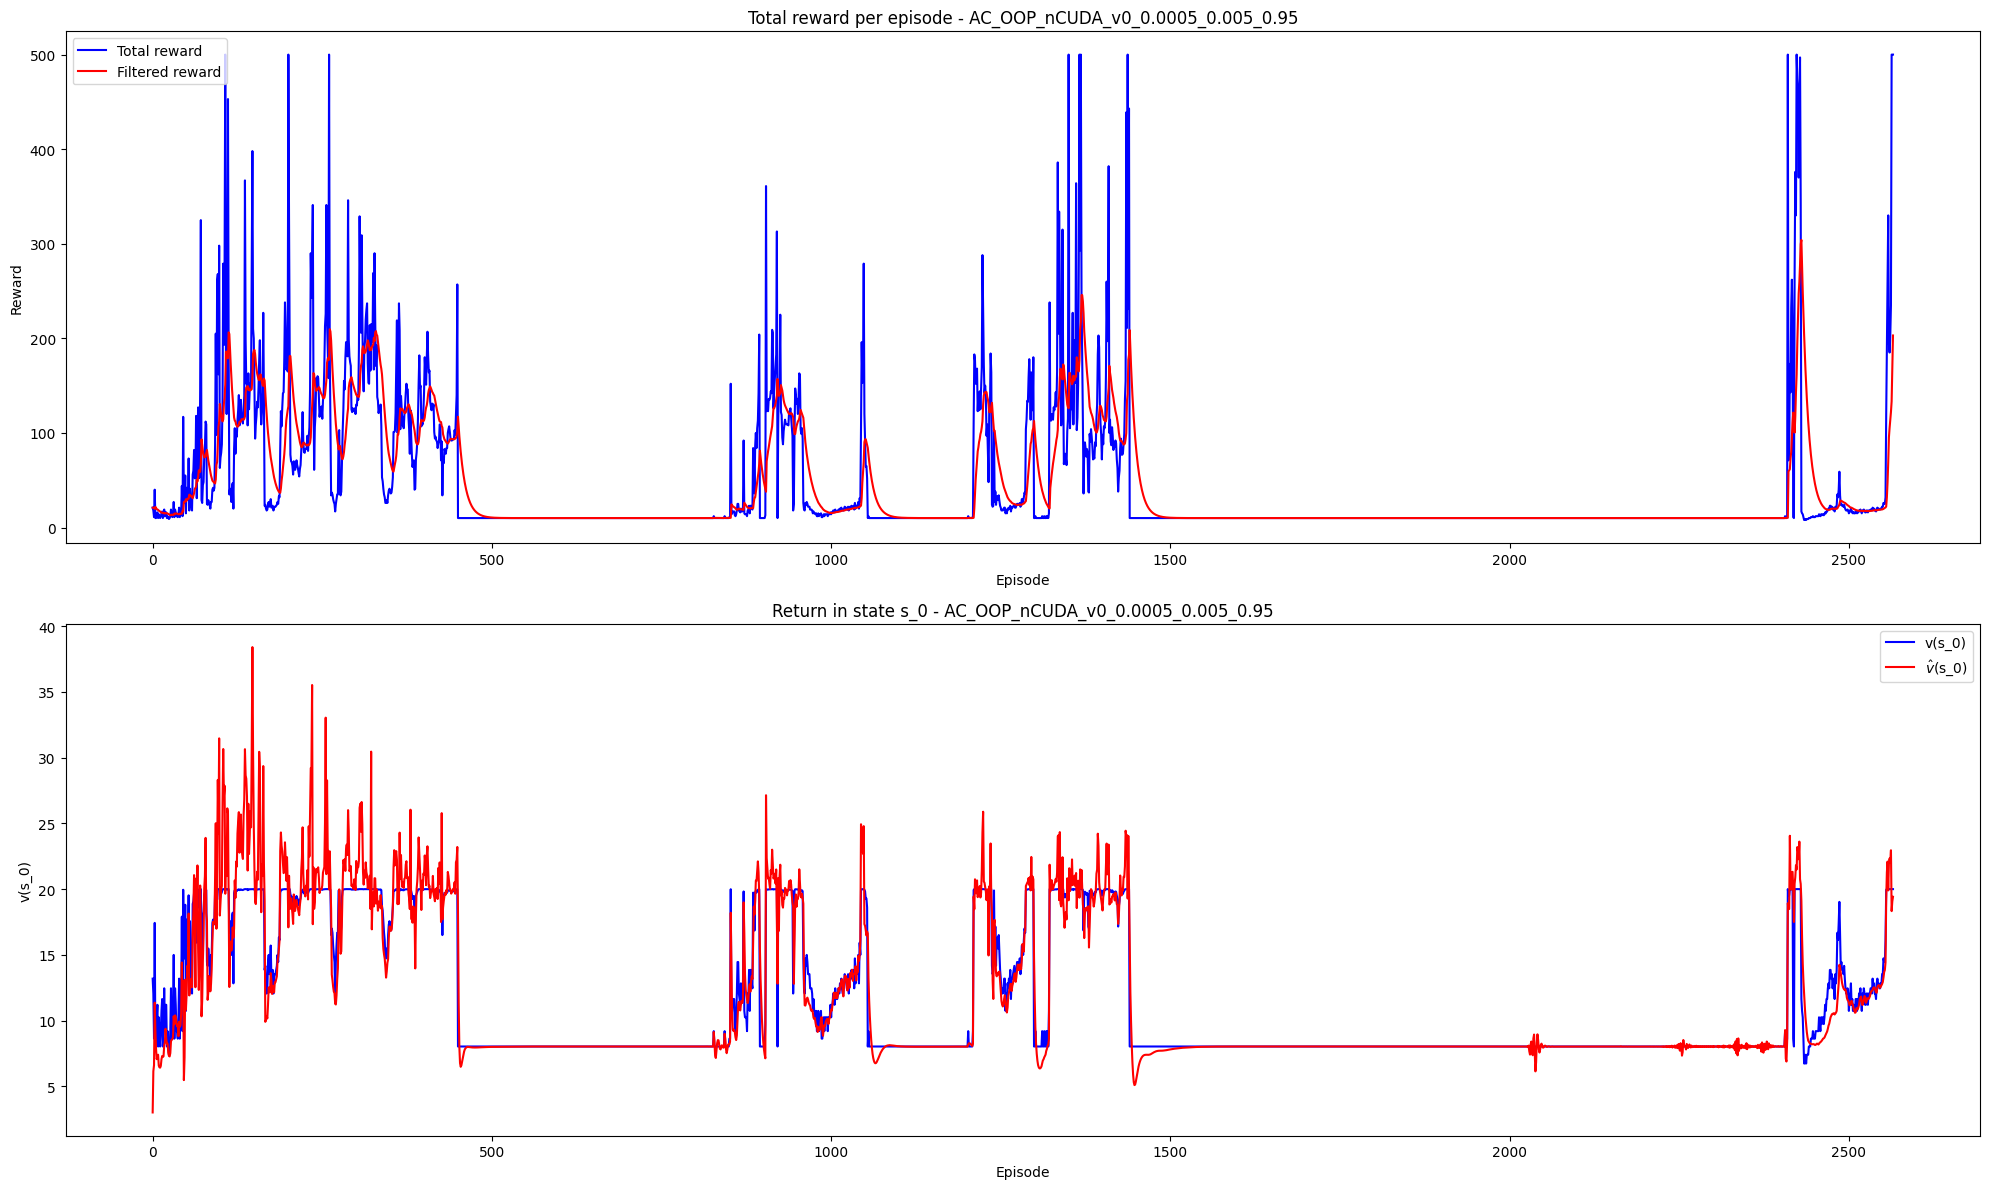

Actor Critic   |   Model AC_MLP_v0, alpha=0.0005, beta=0.005, gamma=0.98
Episode  4950/5000: Total reward =  10.0   |   G_0 =  9.15   |   $\hat v(s_0)$ =   9.158
Total runtime - 143.94
Training terminated due to episode limit, best model saved at episode   812
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 500.00 (SD = 0.00)


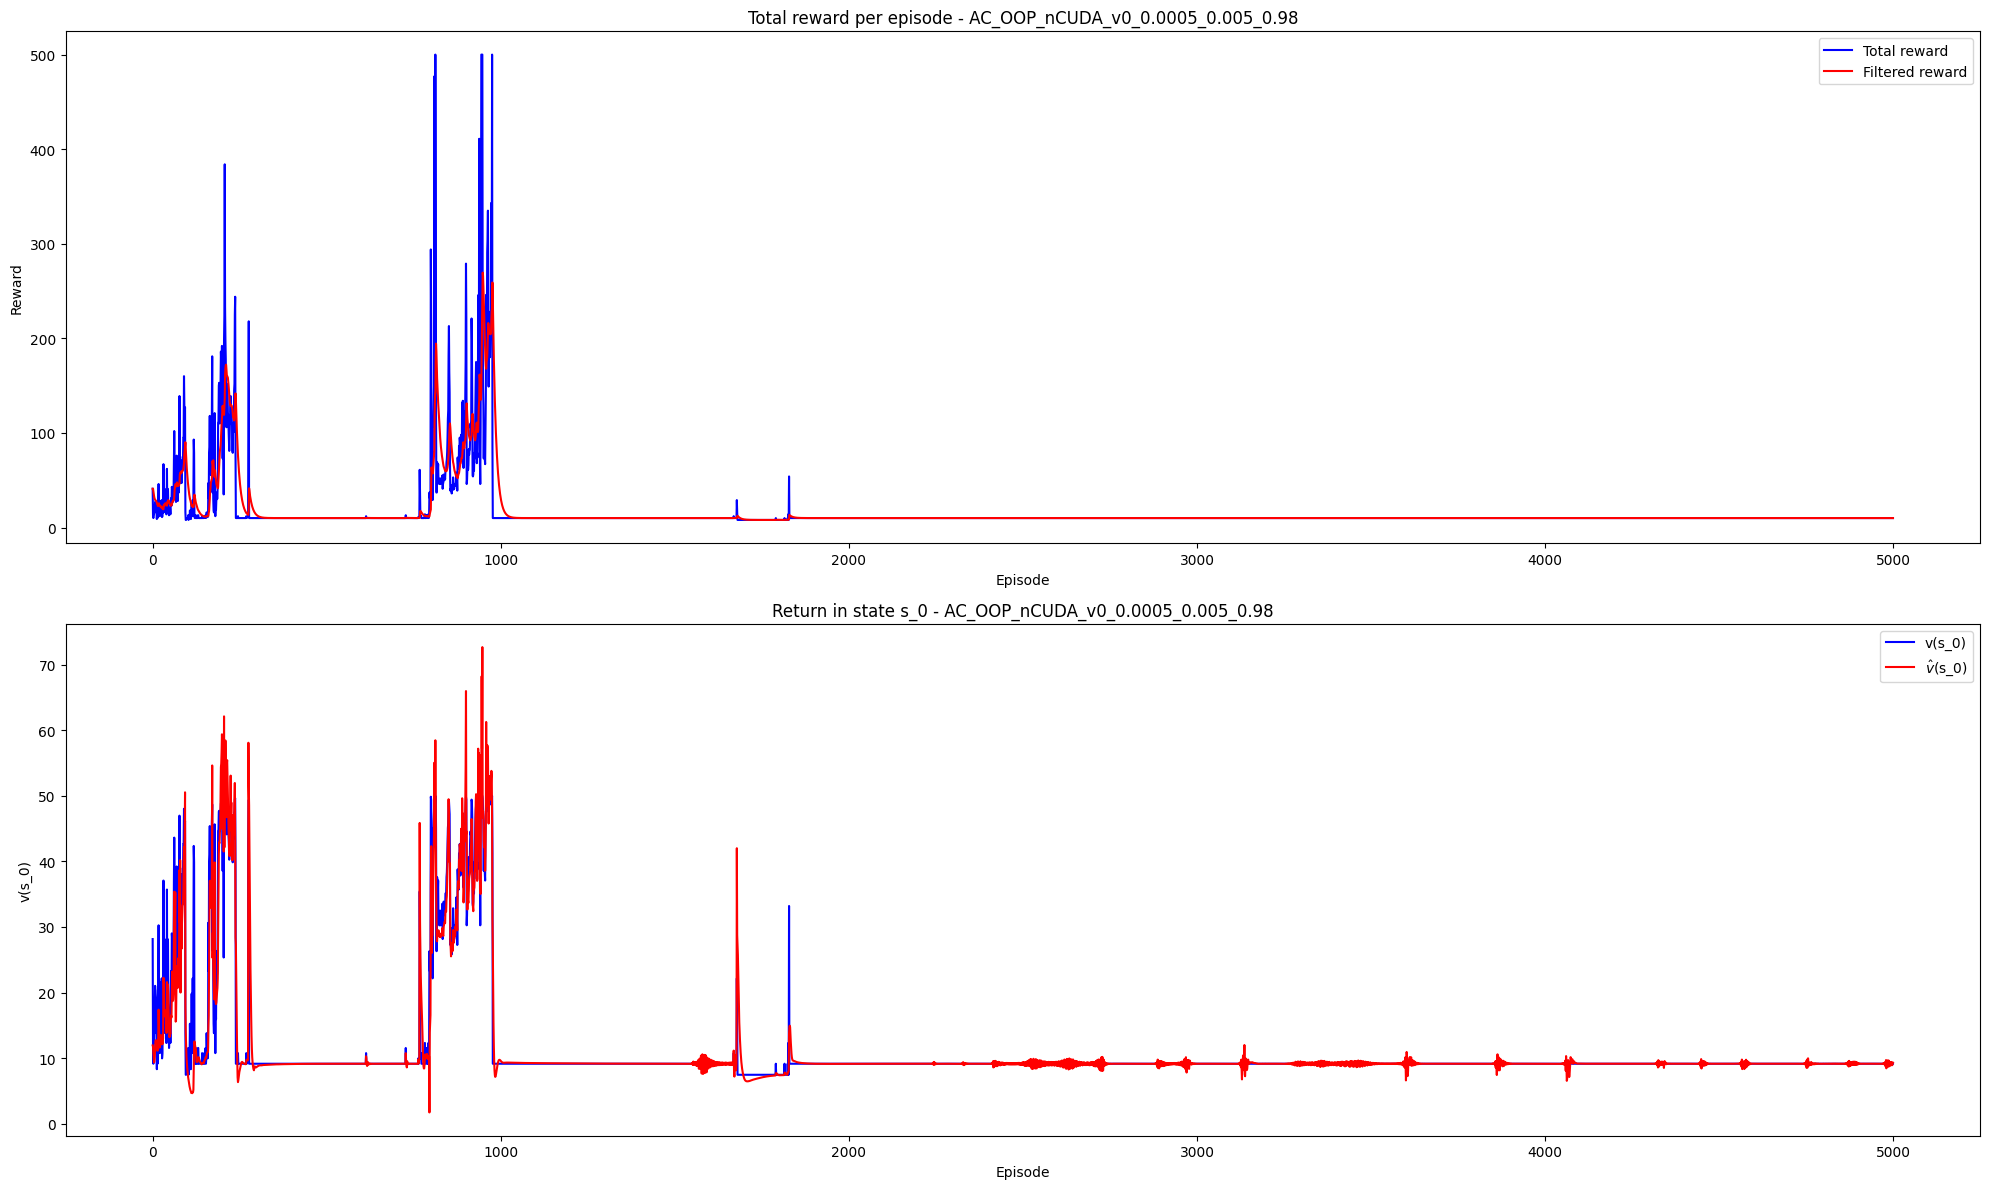

Actor Critic   |   Model AC_MLP_v1, alpha=0.0001, beta=0.001, gamma=0.95
Episode   650/5000: Total reward = 223.0   |   G_0 =  20.00   |   $\hat v(s_0)$ =  20.68
Total runtime - 173.55
Early termination at episode   680, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 489.10 (SD = 52.48)


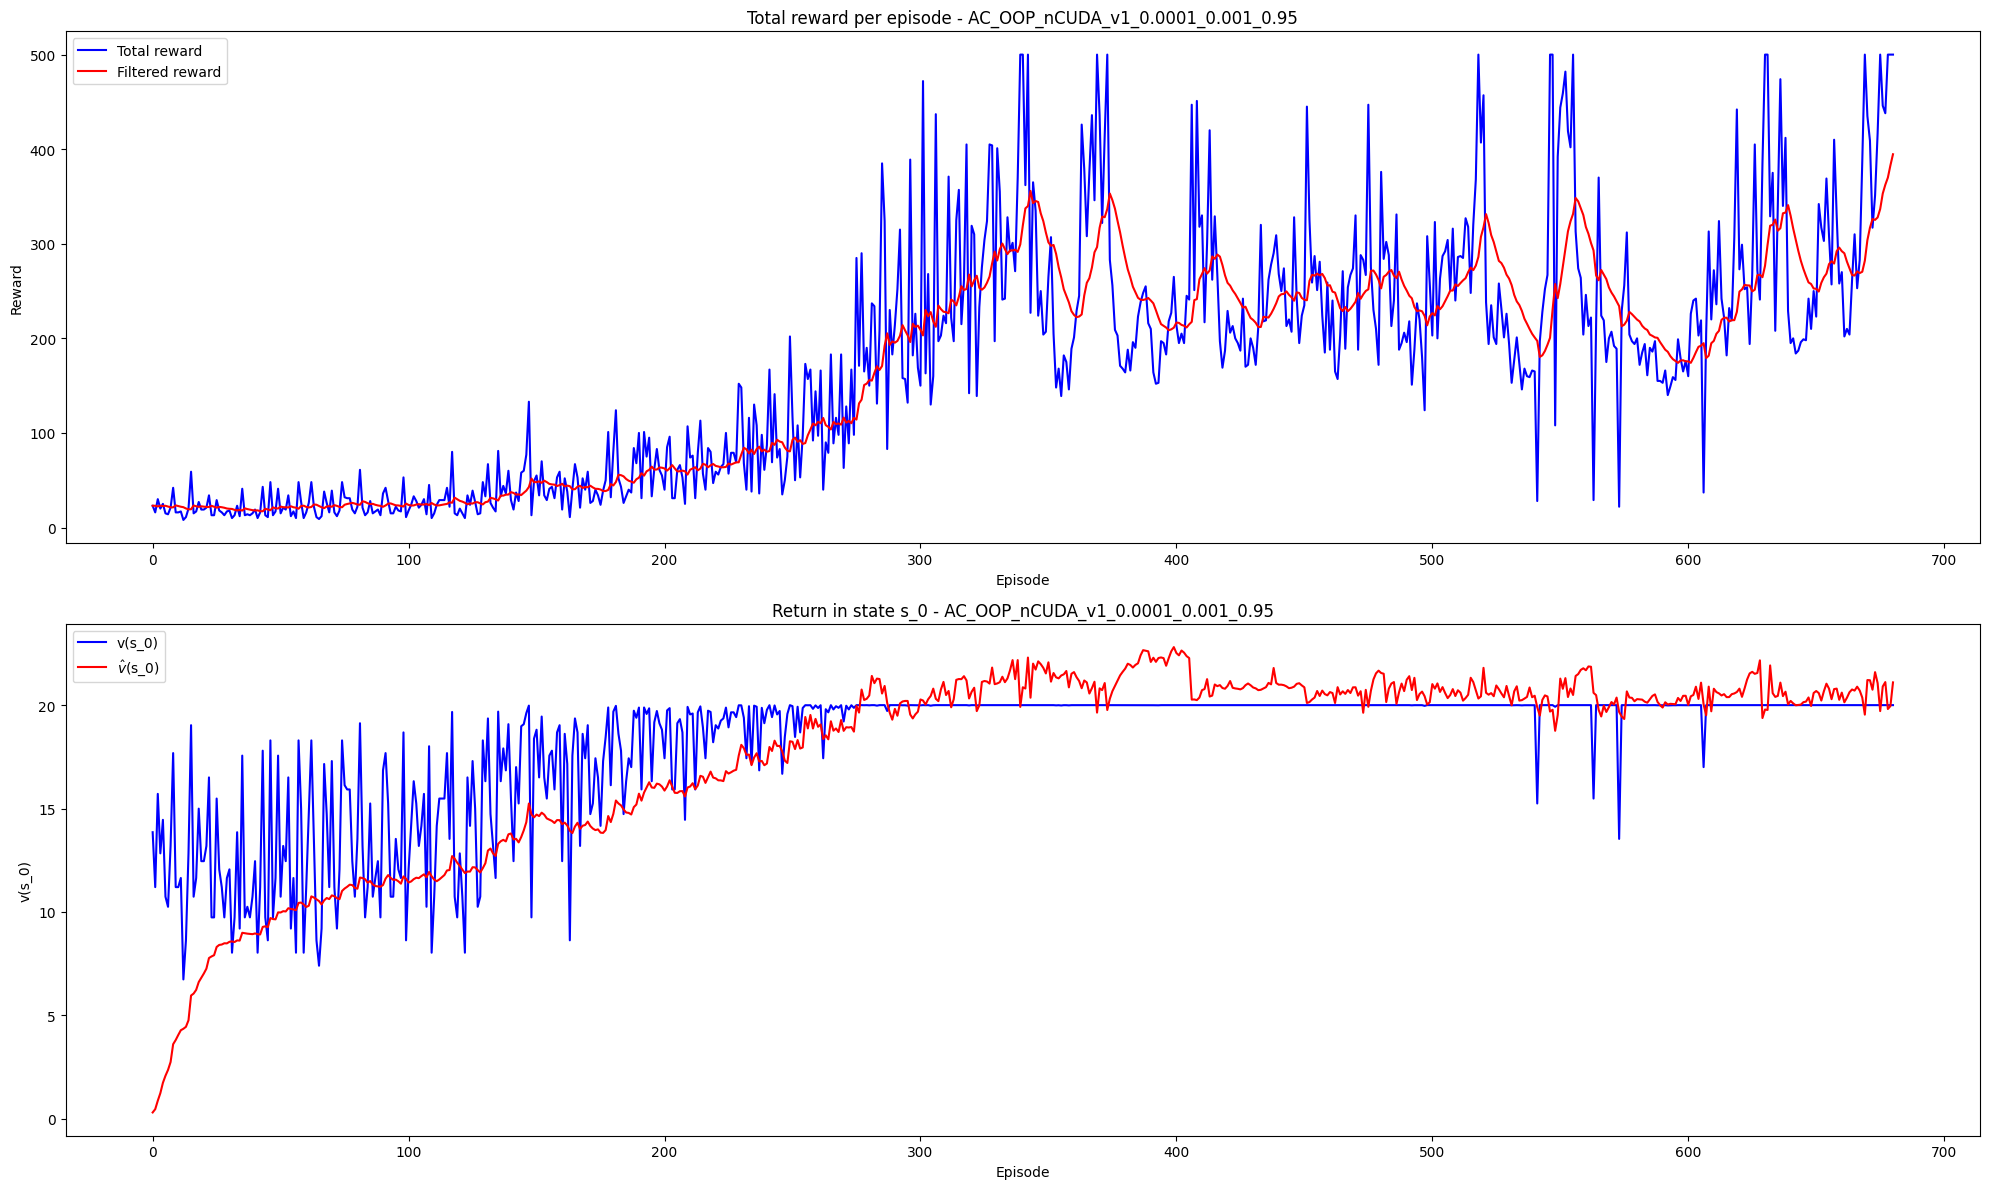

Actor Critic   |   Model AC_MLP_v1, alpha=0.0001, beta=0.001, gamma=0.98
Episode   400/5000: Total reward = 216.0   |   G_0 =  49.36   |   $\hat v(s_0)$ =  50.05
Total runtime - 82.07
Early termination at episode   447, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 487.54 (SD = 56.12)


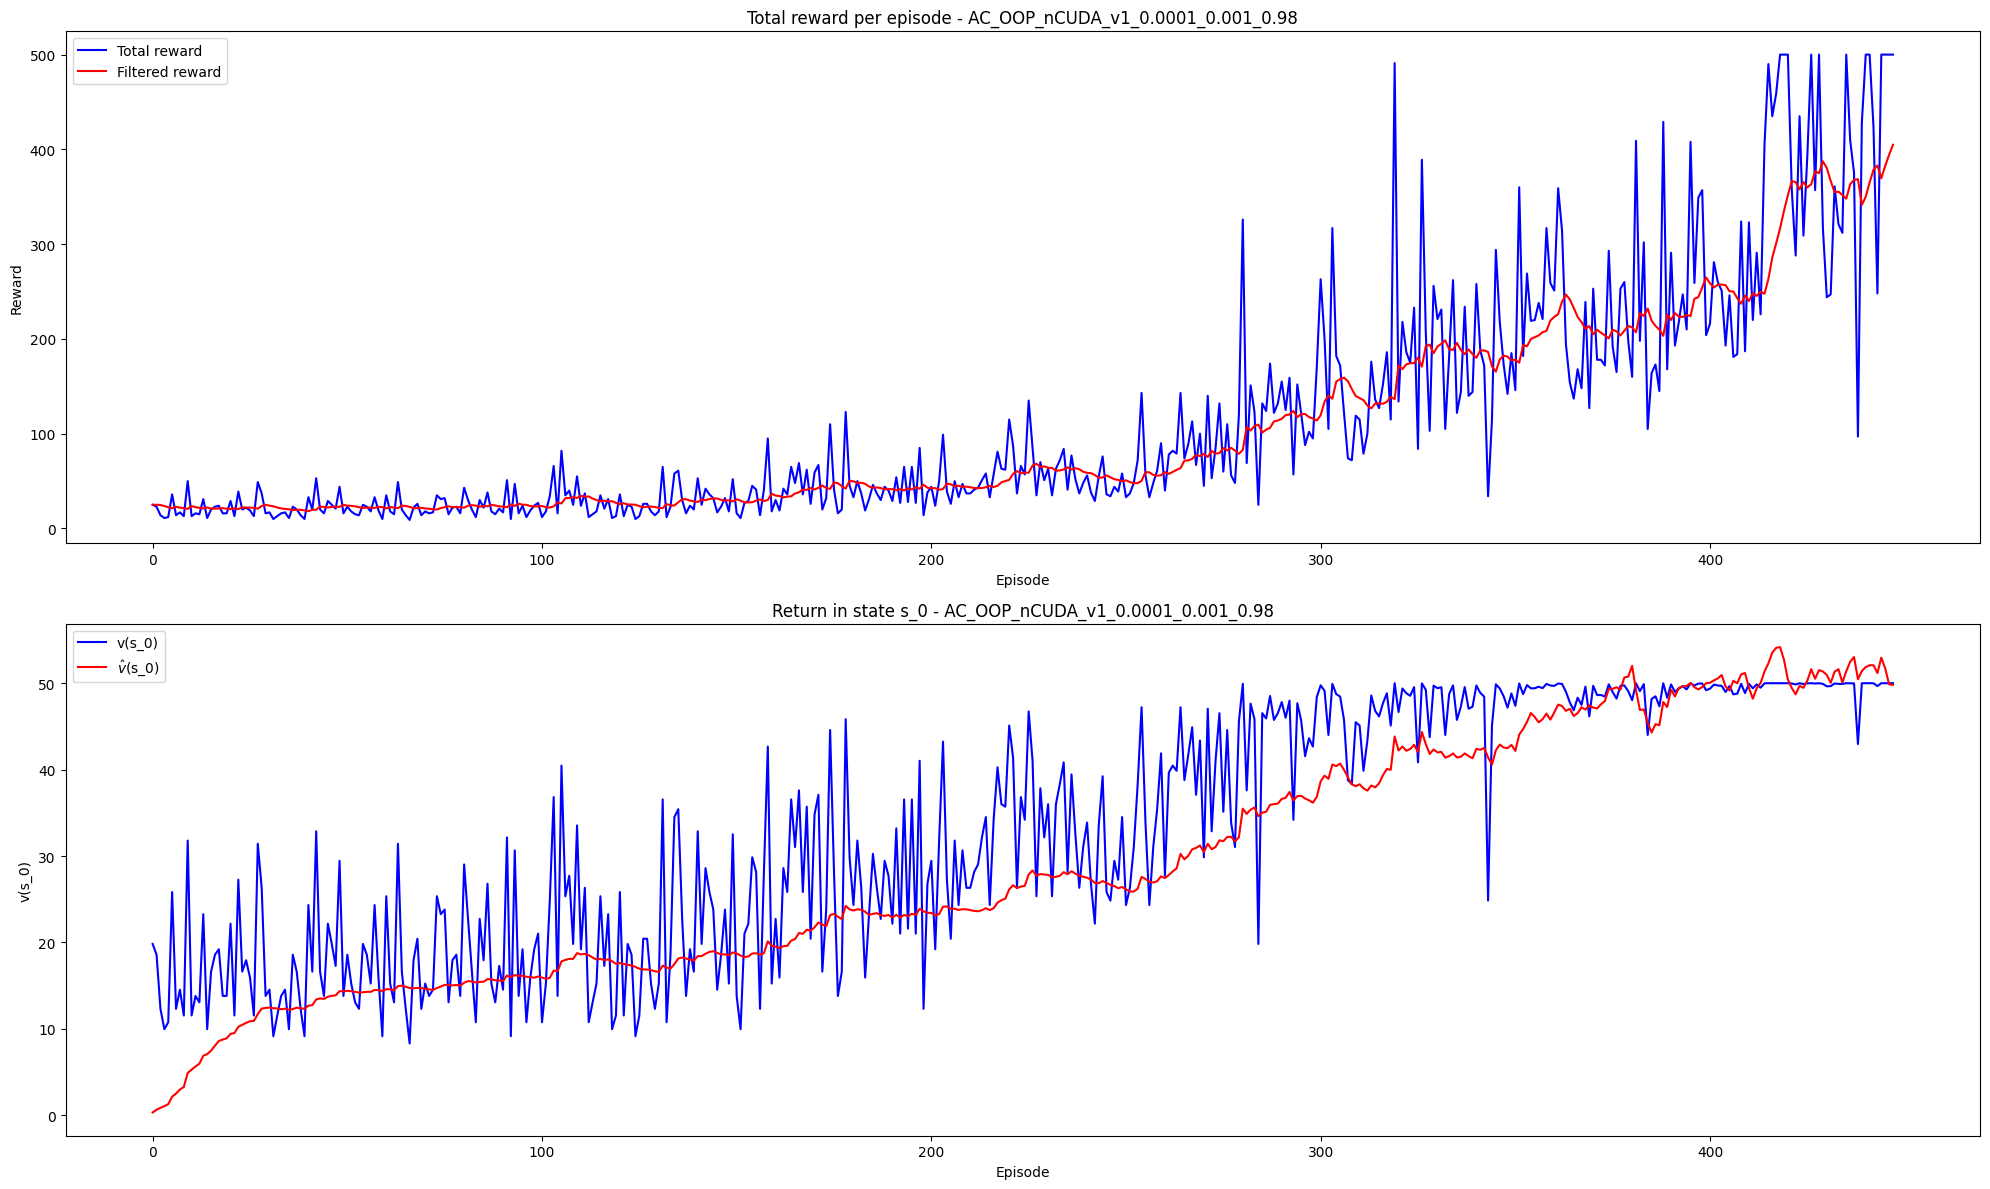

Actor Critic   |   Model AC_MLP_v1, alpha=0.0001, beta=0.005, gamma=0.95
Episode   350/5000: Total reward = 164.0   |   G_0 =  20.00   |   $\hat v(s_0)$ =  19.14
Total runtime - 70.83
Early termination at episode   385, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 465.63 (SD = 76.24)


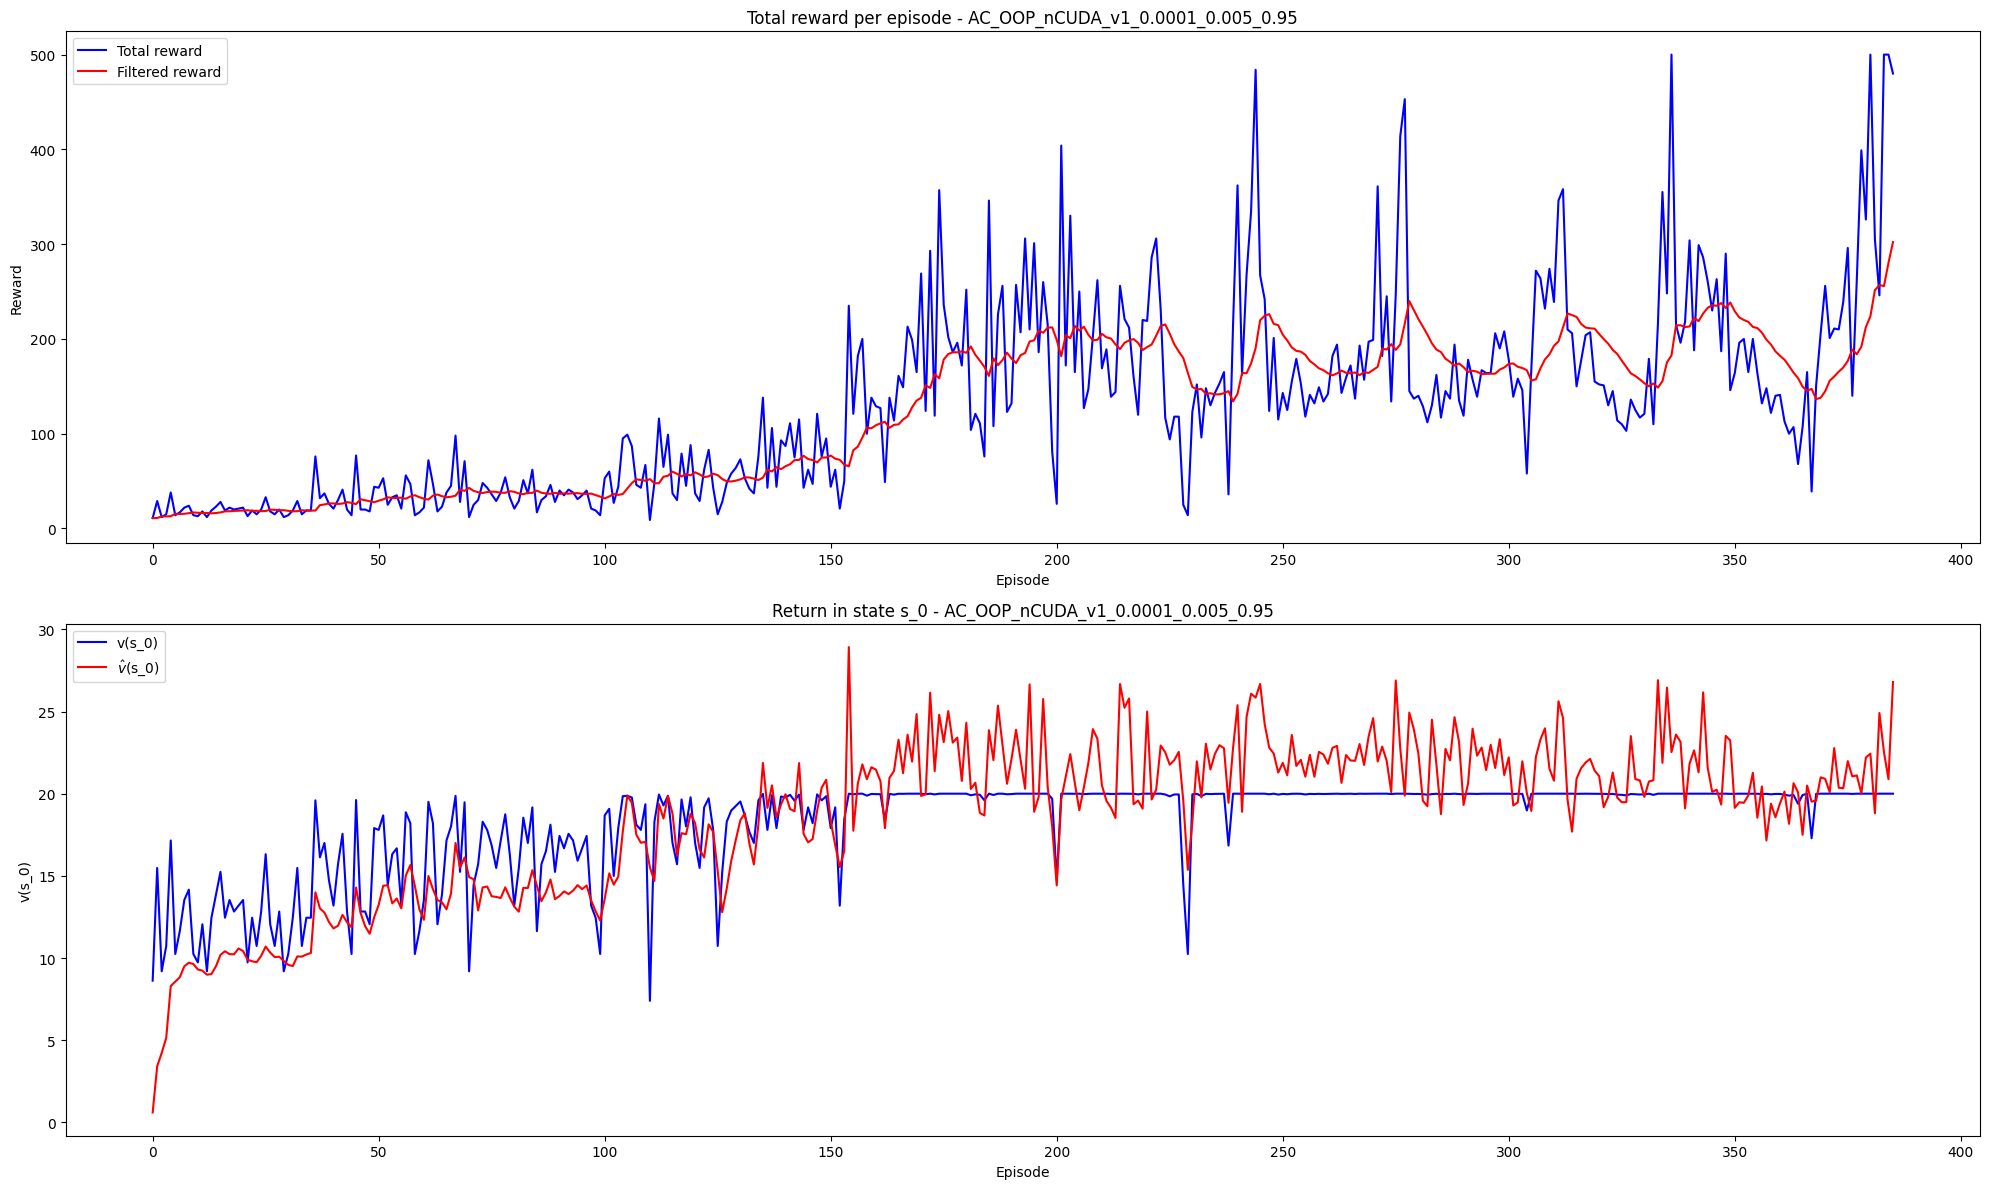

Actor Critic   |   Model AC_MLP_v1, alpha=0.0001, beta=0.005, gamma=0.98
Episode   200/5000: Total reward = 196.0   |   G_0 =  49.05   |   $\hat v(s_0)$ =  49.29
Total runtime - 34.22
Early termination at episode   225, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  408
Validation average reward 460.48 (SD = 77.76)


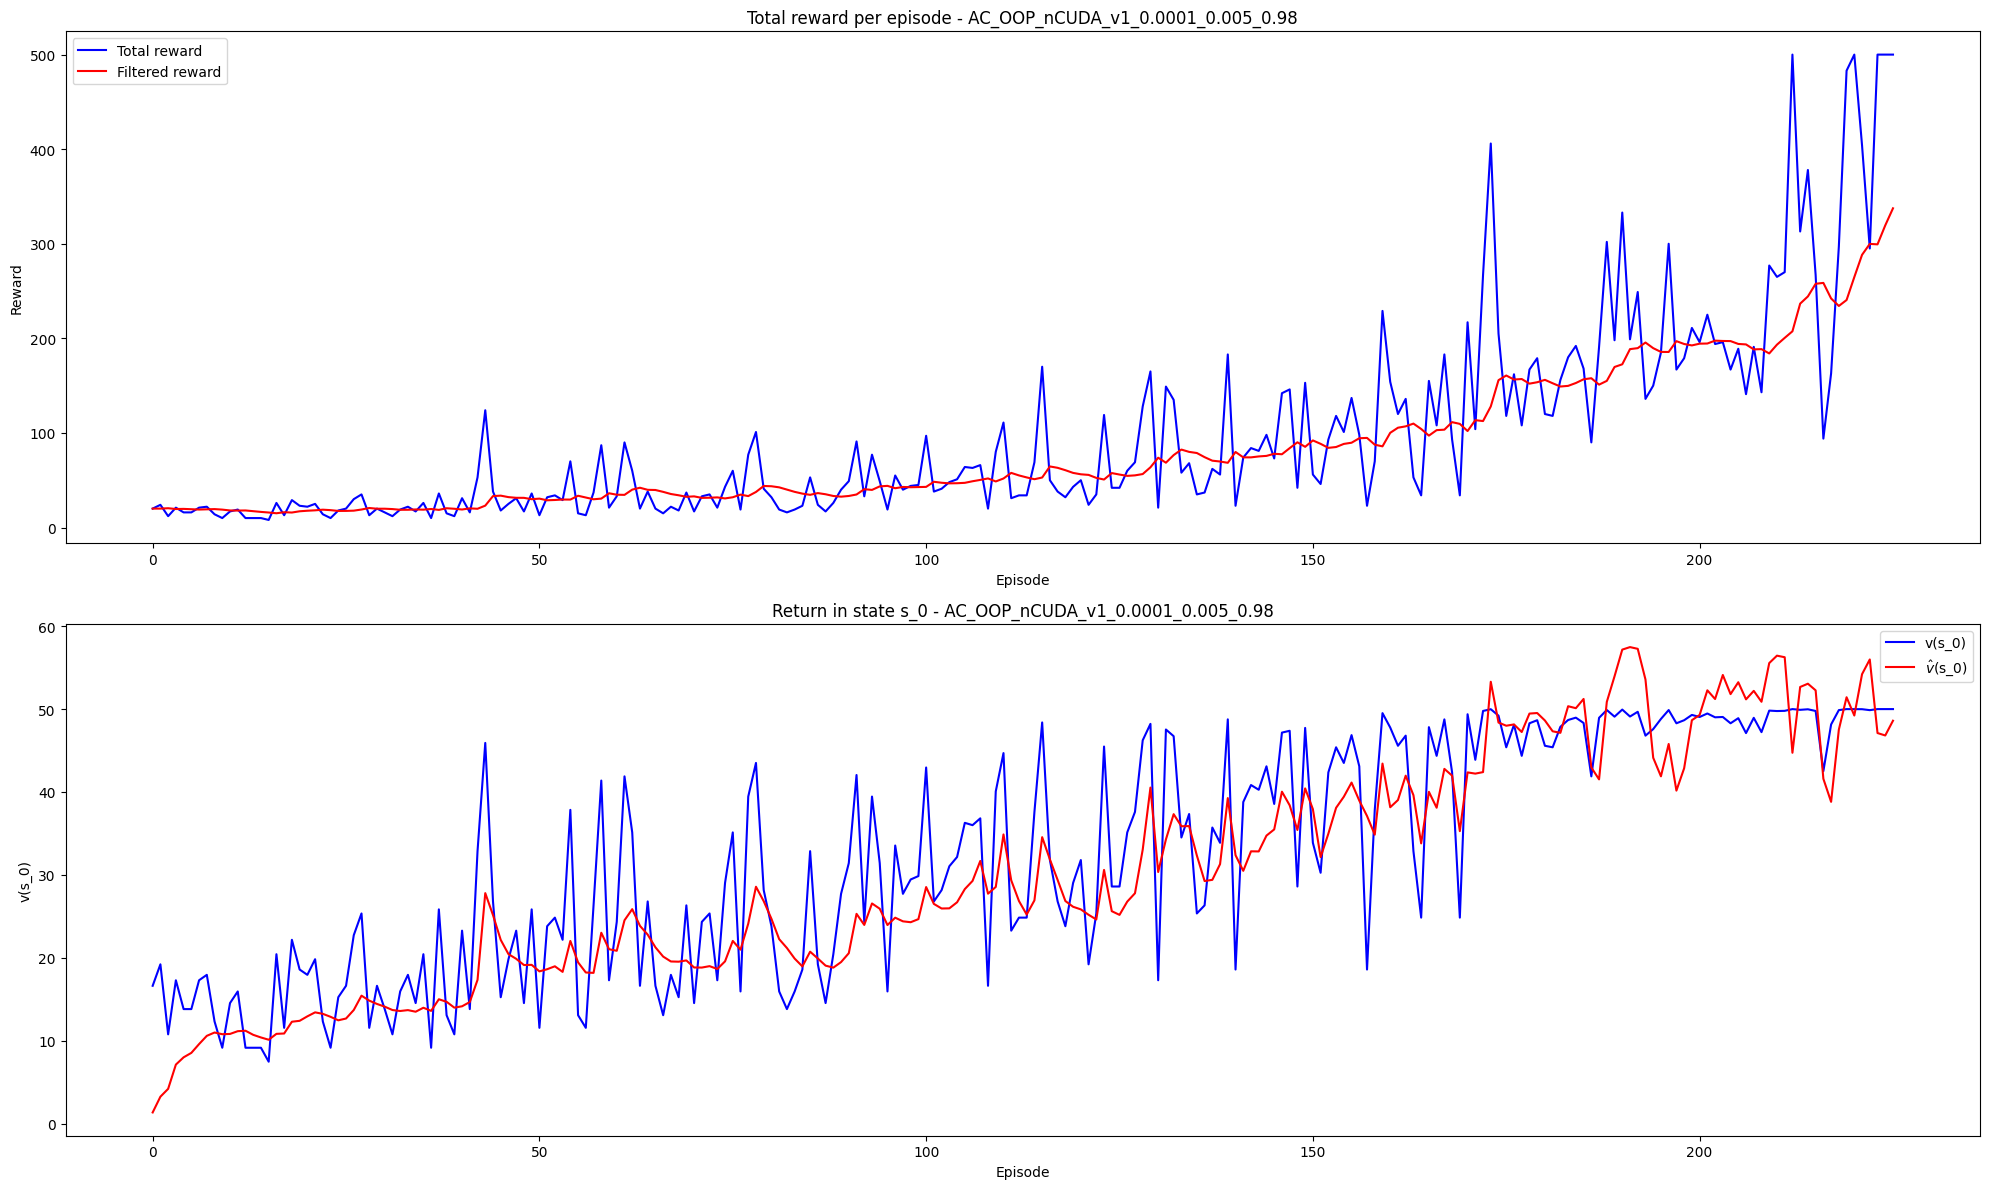

Actor Critic   |   Model AC_MLP_v1, alpha=0.0005, beta=0.001, gamma=0.95
Episode  1250/5000: Total reward = 119.0   |   G_0 =  19.96   |   $\hat v(s_0)$ =  20.08
Total runtime - 244.54
Early termination at episode  1264, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 500.00 (SD = 0.00)


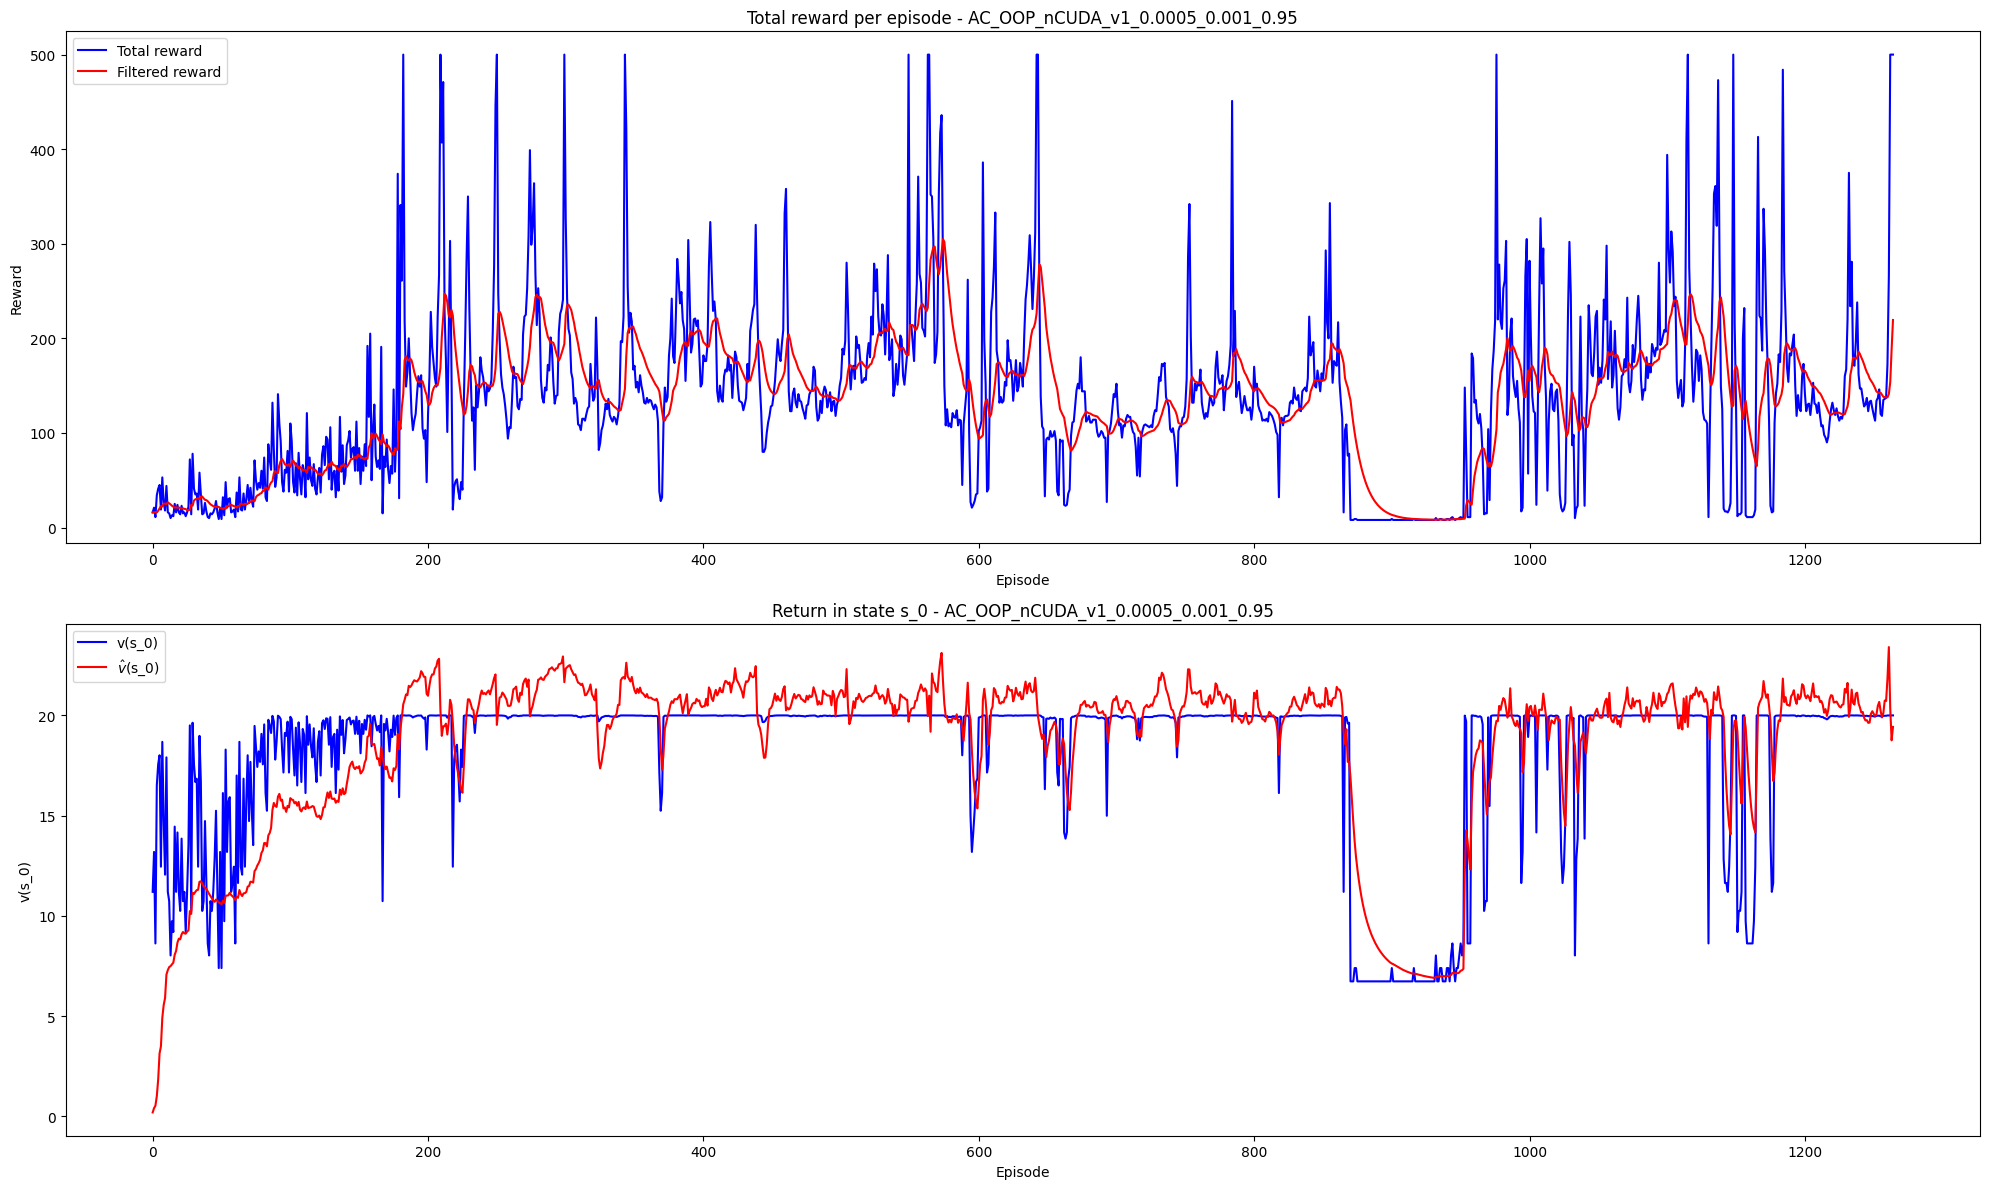

Actor Critic   |   Model AC_MLP_v1, alpha=0.0005, beta=0.001, gamma=0.98
Episode   250/5000: Total reward = 204.0   |   G_0 =  49.19   |   $\hat v(s_0)$ =  47.39
Total runtime - 34.54
Early termination at episode   258, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  500
Validation average reward 499.86 (SD = 2.40)


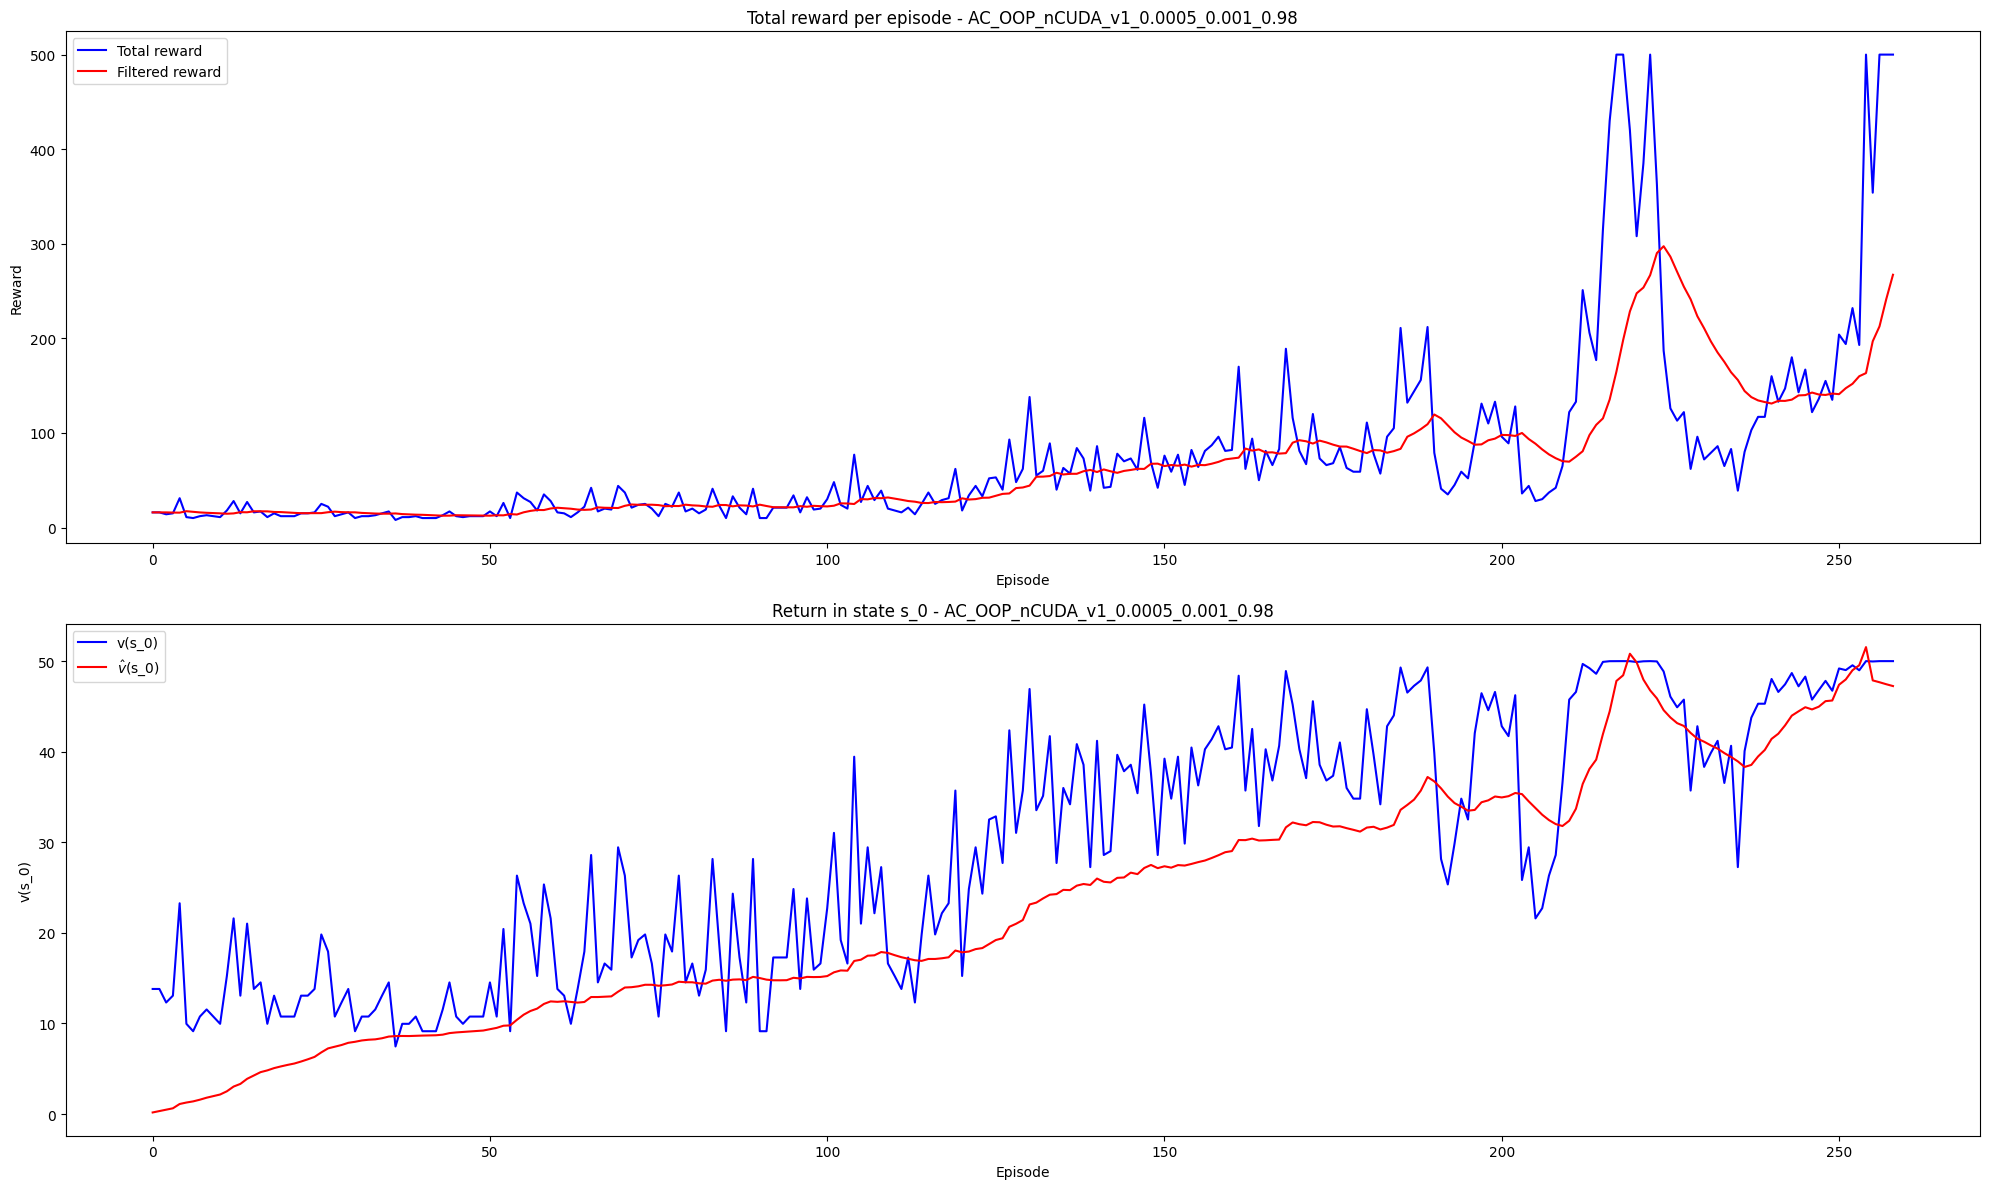

Actor Critic   |   Model AC_MLP_v1, alpha=0.0005, beta=0.005, gamma=0.95


In [ ]:
import itertools
keys, values = zip(*param_grid.items())
num_config = len(list(itertools.product(*values)))

seed = 42
np.random.seed(seed); torch.manual_seed(seed)

for idx, v in enumerate(itertools.product(*values)):
    # Unpack the hyperparameters configurations
    config = dict(zip(keys,v))
    MODEL_NAME = config['MODEL']
    MODEL_CLASS = model_registry[MODEL_NAME]['class']
    MODEL_CONFIG = model_registry[MODEL_NAME]['config']
    match = re.search(r'v\d+',MODEL_NAME)
    MODEL_ID = match.group(0) if match else 404

    ALPHA = config['ALPHA']
    BETA = config['BETA']
    GAMMA = config['GAMMA']
    N_EPISODE_TRAIN = config['N_EPISODE_TRAIN']
    
    AC_experiment = ActorCritic(MODEL_NAME, 
                                    model_registry,
                                    alpha = ALPHA,
                                    beta = BETA,
                                    gamma = GAMMA,
                                    n_episode_train = N_EPISODE_TRAIN,
                                    seed=42,
                                    cuda_enabled=CUDA_ENABLED,
                                    verbose=True)
    AC_experiment.train_policy()
    AC_experiment.record()

## Load and Simulate a Saved Model

In [ ]:
def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
AC_experiment.save_path

In [ ]:
## Manually select a folder/run to load
run_number = 'run_00043'

## Find the paths to the param_config and model checkpoint
# RESULT_DIR = os.path.dirname(REINFORCE_experiment.save_path)    # Can run this after running one experiment
RESULT_DIR = 'c:\\mnguyen\\experiment\\DRL\\gym_exercise\\inv_pend_AC_results'
RUN_DIR = os.path.join(RESULT_DIR, run_number)
MODEL_PATH = os.path.join(RUN_DIR,'q_network_checkpoint.pth')

## Find the model configuration
with open(os.path.join(RUN_DIR,"param_config.json"),'r') as f:
    data = json.load(f)
model_name = data['parameters']['model_name']
model_config = model_registry[model_name]['config']

# Create the model according to the model version in the model registry
policy_net_loaded = PolicyNet(AC_experiment.obs_space, AC_experiment.act_space, model_config)
load_model(policy_net_loaded, MODEL_PATH)

# Create a visual simulation of the network
RENDER_MODE = "human"
env_test_visual = gym.make("CartPole-v1",render_mode=RENDER_MODE)
num_test = 1

for episode in range(num_test):
    obs, _ = env_test_visual.reset()
    done = False
    eps_reward = 0

    while not done:
        obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if CUDA_ENABLED else 'cpu')
        action_probs = policy_net_loaded(obs_tensor)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        next_obs, reward, term, trunc, _ = env_test_visual.step(action.item())

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")